# コロナ発症有無による糖尿病リスクの違いについての疫学分析

## 1.分析概要

JAST 日本システム技術株式会社提供のレセプトデータを使用。  
データを以下のフローチャートに基づき処理し、  
コロナ感染者：コロナ非感染者 = 1:4　のcohort matchingを適用。  
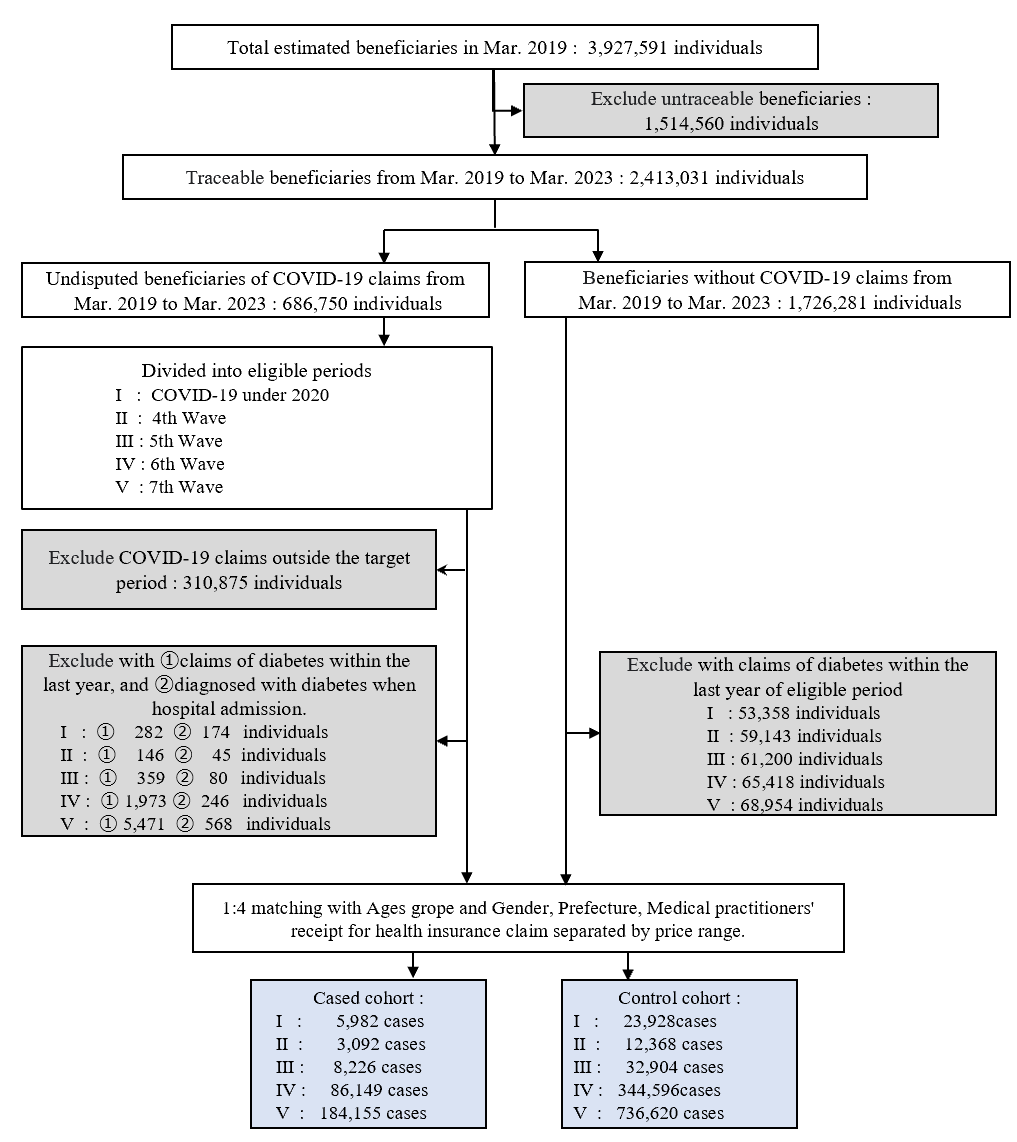

コロナの波別でCOX分析を実施し、追跡期間1年間の間でコロナ感染が糖尿病発症に影響するのかを調査  

### cox分析用データの前処理部分解説 
・以下の表が、観測開始日・終了日に関して、前処理の場合分けを表しています。(1年の場合)  
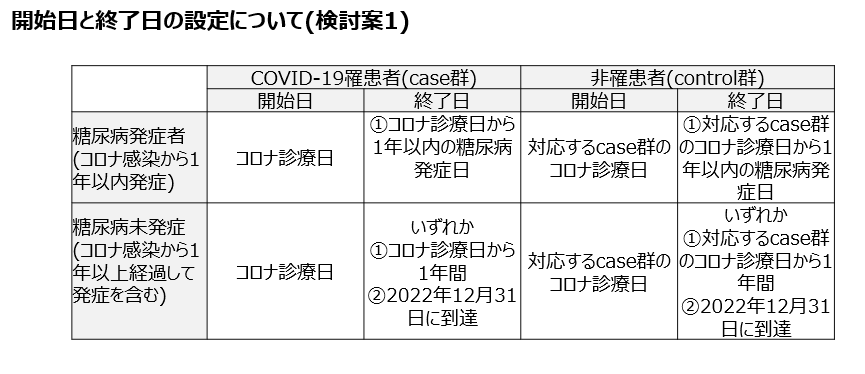

## 2.分析

### モジュールのimport 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from datetime import datetime
from tqdm import tqdm
# import japanize_matplotlib

### cox分析用データ作成コード

In [20]:
# 分析のバージョンを示す変数を定義
version = '前処理あり_v2' # '前処理あり' or '前処理なし'
target_duration = '1y' # 1y or 2m 

# 空の辞書を作成
cox_dict = {}

# 分析対象のデータのラベルのリスト
data_list = ['2020年度', '第4波', '第5波', '第6波', '第7波']

# 各データ波の期間を示す辞書
duration_dict = {
    '2020年度': [20200401, 20210331],
    '第4波': [20210401, 20210531],
    '第5波': [20210701, 20210930],
    '第6波': [20220101, 20220331],
    '第7波': [20220701, 20220930]
}

# フォントの設定
plt.rcParams["font.family"] = 'MS Gothic'

# data_list内の各データに対して処理を実行
for wave in tqdm(data_list):
    # CSVファイルからデータを読み込む
    data = pd.read_csv(f'{wave}_12ヶ月以内診療_1to4_matching(shift-jis).csv', encoding='shift-jis')
    
    # データの列 'case_control' の値に基づいて 'covid_flag' 列を追加
    data['covid_flag'] = np.where(data['case_control'] == 'case', 1, 0)
    
    # 'case_group' 列のデータ型をfloatから文字列に変換
    data['case_group'] = data['case_group'].astype('int').astype('str')
    
    # 'age_kbn' 列の一部の値を置換
    data['age_kbn'] = np.where(data['age_kbn'].isin(['6_60代', '7_70歳以上']), '6_60代以上', data['age_kbn'])
    
    # 必要な列のみを抽出し、データを再構築
    data = data[['patient_id', 'sex_type_nm', 'age', 'age_kbn', 'pref_nm', 'covid_start_date.1', 'longcovid_start_date.1', 'longcovid_start_date.2', 'covid_flag', 'case_group']].reset_index(drop=True)
    
    # 'diabetes_date' 列に、糖尿病感染者の場合は日付を、そうでなければnanを追加
    data['diabetes_date'] = np.where(data['longcovid_start_date.1'] != '-', data['longcovid_start_date.1'], np.nan)
    data['diabetes_date'] = np.where(data['longcovid_start_date.2'] != '-', data['longcovid_start_date.2'], data['diabetes_date'])
    
    # 列 'diabetes_date' を日付型に変換
    data['diabetes_date'] = pd.to_datetime(data['diabetes_date'])
    
    # 列 'covid_start_date' の欠損を表す'-'をnanに置換
    data['covid_start_date'] = np.where(data['covid_start_date.1'] != '-', data['covid_start_date.1'], np.nan)
    
    # 列 'covid_start_date' を日付型に変換
    data['covid_start_date'] = pd.to_datetime(data['covid_start_date'])
    
    # 不要な列を削除
    data.drop(columns=['covid_start_date.1', 'longcovid_start_date.1', 'longcovid_start_date.2'], inplace=True)
    
    # 各ケースグループごとに処理を実行
    #control群の'case_covid_date'列に、case群のコロナ感染日を入力
    for i in data['case_group'].unique():
        st_date = data.loc[(data['case_group'] == i) & (data['covid_flag'] == 1), 'covid_start_date']
        data.loc[data['case_group'] == i, 'case_covid_date'] = st_date.reset_index(drop=True)[0]
    
    # CSVファイルから病院データを読み込む
    hospital_data = pd.read_csv(f'{wave}_糖尿病_DPC入退院歴.csv', encoding='cp932')
    
    # 病院データを日付でソート
    hospital_data.sort_values('dpc_in_date', inplace=True)
    
    # 期間に基づいて病院データをフィルタリング
    # 対象期間外の入院データを除外
    min_ = duration_dict[wave][0]
    max_ = duration_dict[wave][1]
    hospital_data = hospital_data.query(f'{min_} < dpc_in_date & {max_} > dpc_in_date')
    
    # 重複する行を削除
    hospital_data = hospital_data.drop_duplicates(subset='patient_id', keep='first')
    
    # 列のデータ型を文字列に変換
    hospital_data = hospital_data.astype(str)
    
    # 列 'dpc_in_date' を日付型に変換
    hospital_data['dpc_in_date'] = pd.to_datetime(hospital_data['dpc_in_date'])
    
    # データを結合
    # 元データに病院データを統合
    data = data.merge(hospital_data, on='patient_id', how='left')
    
    # 列 'dpc_out_date' を削除
    data.drop(columns=['dpc_out_date'], inplace=True)
    
    # 日数の差を計算して新たな列 'diabetes_days' を追加
    data['diabetes_days'] = (data['diabetes_date'] - data['case_covid_date'])
    data['diabetes_days'] = data['diabetes_days'].map(lambda x: x.days)

    if target_duration == '1y':
        # 特定の条件に基づいて 'Diabetes_flag_1y' 列を追加
        # case群コロナ感染日から1年以内に糖尿病になったかどうか
        # 前処理ありver:コロナ感染日・入院日当日の発症を除く
        data = data[(data['diabetes_days']>=1)|(data['diabetes_days'].isnull())]
        data = data[data['dpc_in_date']!=data['diabetes_date']]
        data['Diabetes_flag_1y'] = np.where((data['diabetes_days'] <= 365), 1, 0)

        # 特定の日付を基準にした '_diabetes_days' 列を追加
        # 2022/12/31日とコロナ感染日の日数差を計算：max365日。これは観測期間の最大値を1年としているため。
        data['_diabetes_days'] = (datetime(2022, 12, 31) - data['case_covid_date'])
        data['_diabetes_days'] = data['_diabetes_days'].map(lambda x: x.days)
        data['_diabetes_days'] = np.where(data['_diabetes_days'] > 365, 365, data['_diabetes_days'])

    # elif target_duration == '2m':
    #     # 特定の条件に基づいて 'Diabetes_flag_2m' 列を追加
    #     # case群コロナ感染日から2ヶ月以内に糖尿病になったかどうか
    #     # 前処理ありver:コロナ感染日・入院日当日の発症を除く
    #     data['Diabetes_flag_2m'] = np.where((data['diabetes_days'] >= 1) & (data['diabetes_days'] <= 60), 1, 0)
    #     data['Diabetes_flag_2m'] = np.where((data['dpc_in_date']==data['diabetes_date']), 0, data['Diabetes_flag_2m'])  

    #     # 特定の日付を基準にした '_diabetes_days' 列を追加
    #     # 2022/12/31日とコロナ感染日の日数差を計算：max365日。これは観測期間の最大値を1年としているため。
    #     data['_diabetes_days'] = (datetime(2022, 12, 31) - data['case_covid_date'])
    #     data['_diabetes_days'] = data['_diabetes_days'].map(lambda x: x.days)
    #     data['_diabetes_days'] = np.where(data['_diabetes_days'] > 60, 60, data['_diabetes_days'])   
    
    # 'Diabetes_flag_1y' 列の値に基づいて 'diabetes_days' 列の値を更新
    # コロナ感染日から1年以内に糖尿病になった患者：コロナ感染から糖尿病になるまでの日数、それ以外：2022/12/31日とコロナ感染日の日数差
    data['diabetes_days'] = np.where(data[f'Diabetes_flag_{target_duration}'] == 1, data['diabetes_days'], data['_diabetes_days'])
    
    # 不要な列を削除
    data.drop(columns=['_diabetes_days'], inplace=True)

    # ダミー変数に変換(年齢区分、性別、都道府県)
    data_with_dummies = pd.get_dummies(data, columns=['sex_type_nm', 'age_kbn', 'pref_nm'])
    # cox分析に不要な変数を除外
    data_with_dummies.drop(columns=['patient_id', 'age',  'case_group', 'diabetes_date', 'covid_start_date', 'case_covid_date', 'dpc_in_date'], inplace=True)
    data_with_dummies.to_csv(f'cox分析用データ_{wave}_{version}_{target_duration}.csv', encoding='cp932', index=False)

100%|██████████| 5/5 [4:24:01<00:00, 3168.39s/it]


### cox分析
グラフより、2020年度、4波、5波のコロナ感染者において、生存率(糖尿病に発症しない確率)がコロナ非感染者と比較して低いことが分かる。  
ここから、コロナ感染が糖尿病発症に寄与していると考えられる。


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\matsuura\anaconda3\lib\site-packages\lifelines\utils\__init__.py:1122: ConvergenceWarning: Column pref_nm_02_青森 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Diabetes_flag_1y'].astype(bool)
>>> print(df.loc[events, 'pref_nm_02_青森'].var())
>>> print(df.loc[~events, 'pref_nm_02_青森'].var())

A very low variance means that the column pref_nm_02_青森 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
c:\Users\matsuura\anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.264. This may imply non-unique solutions

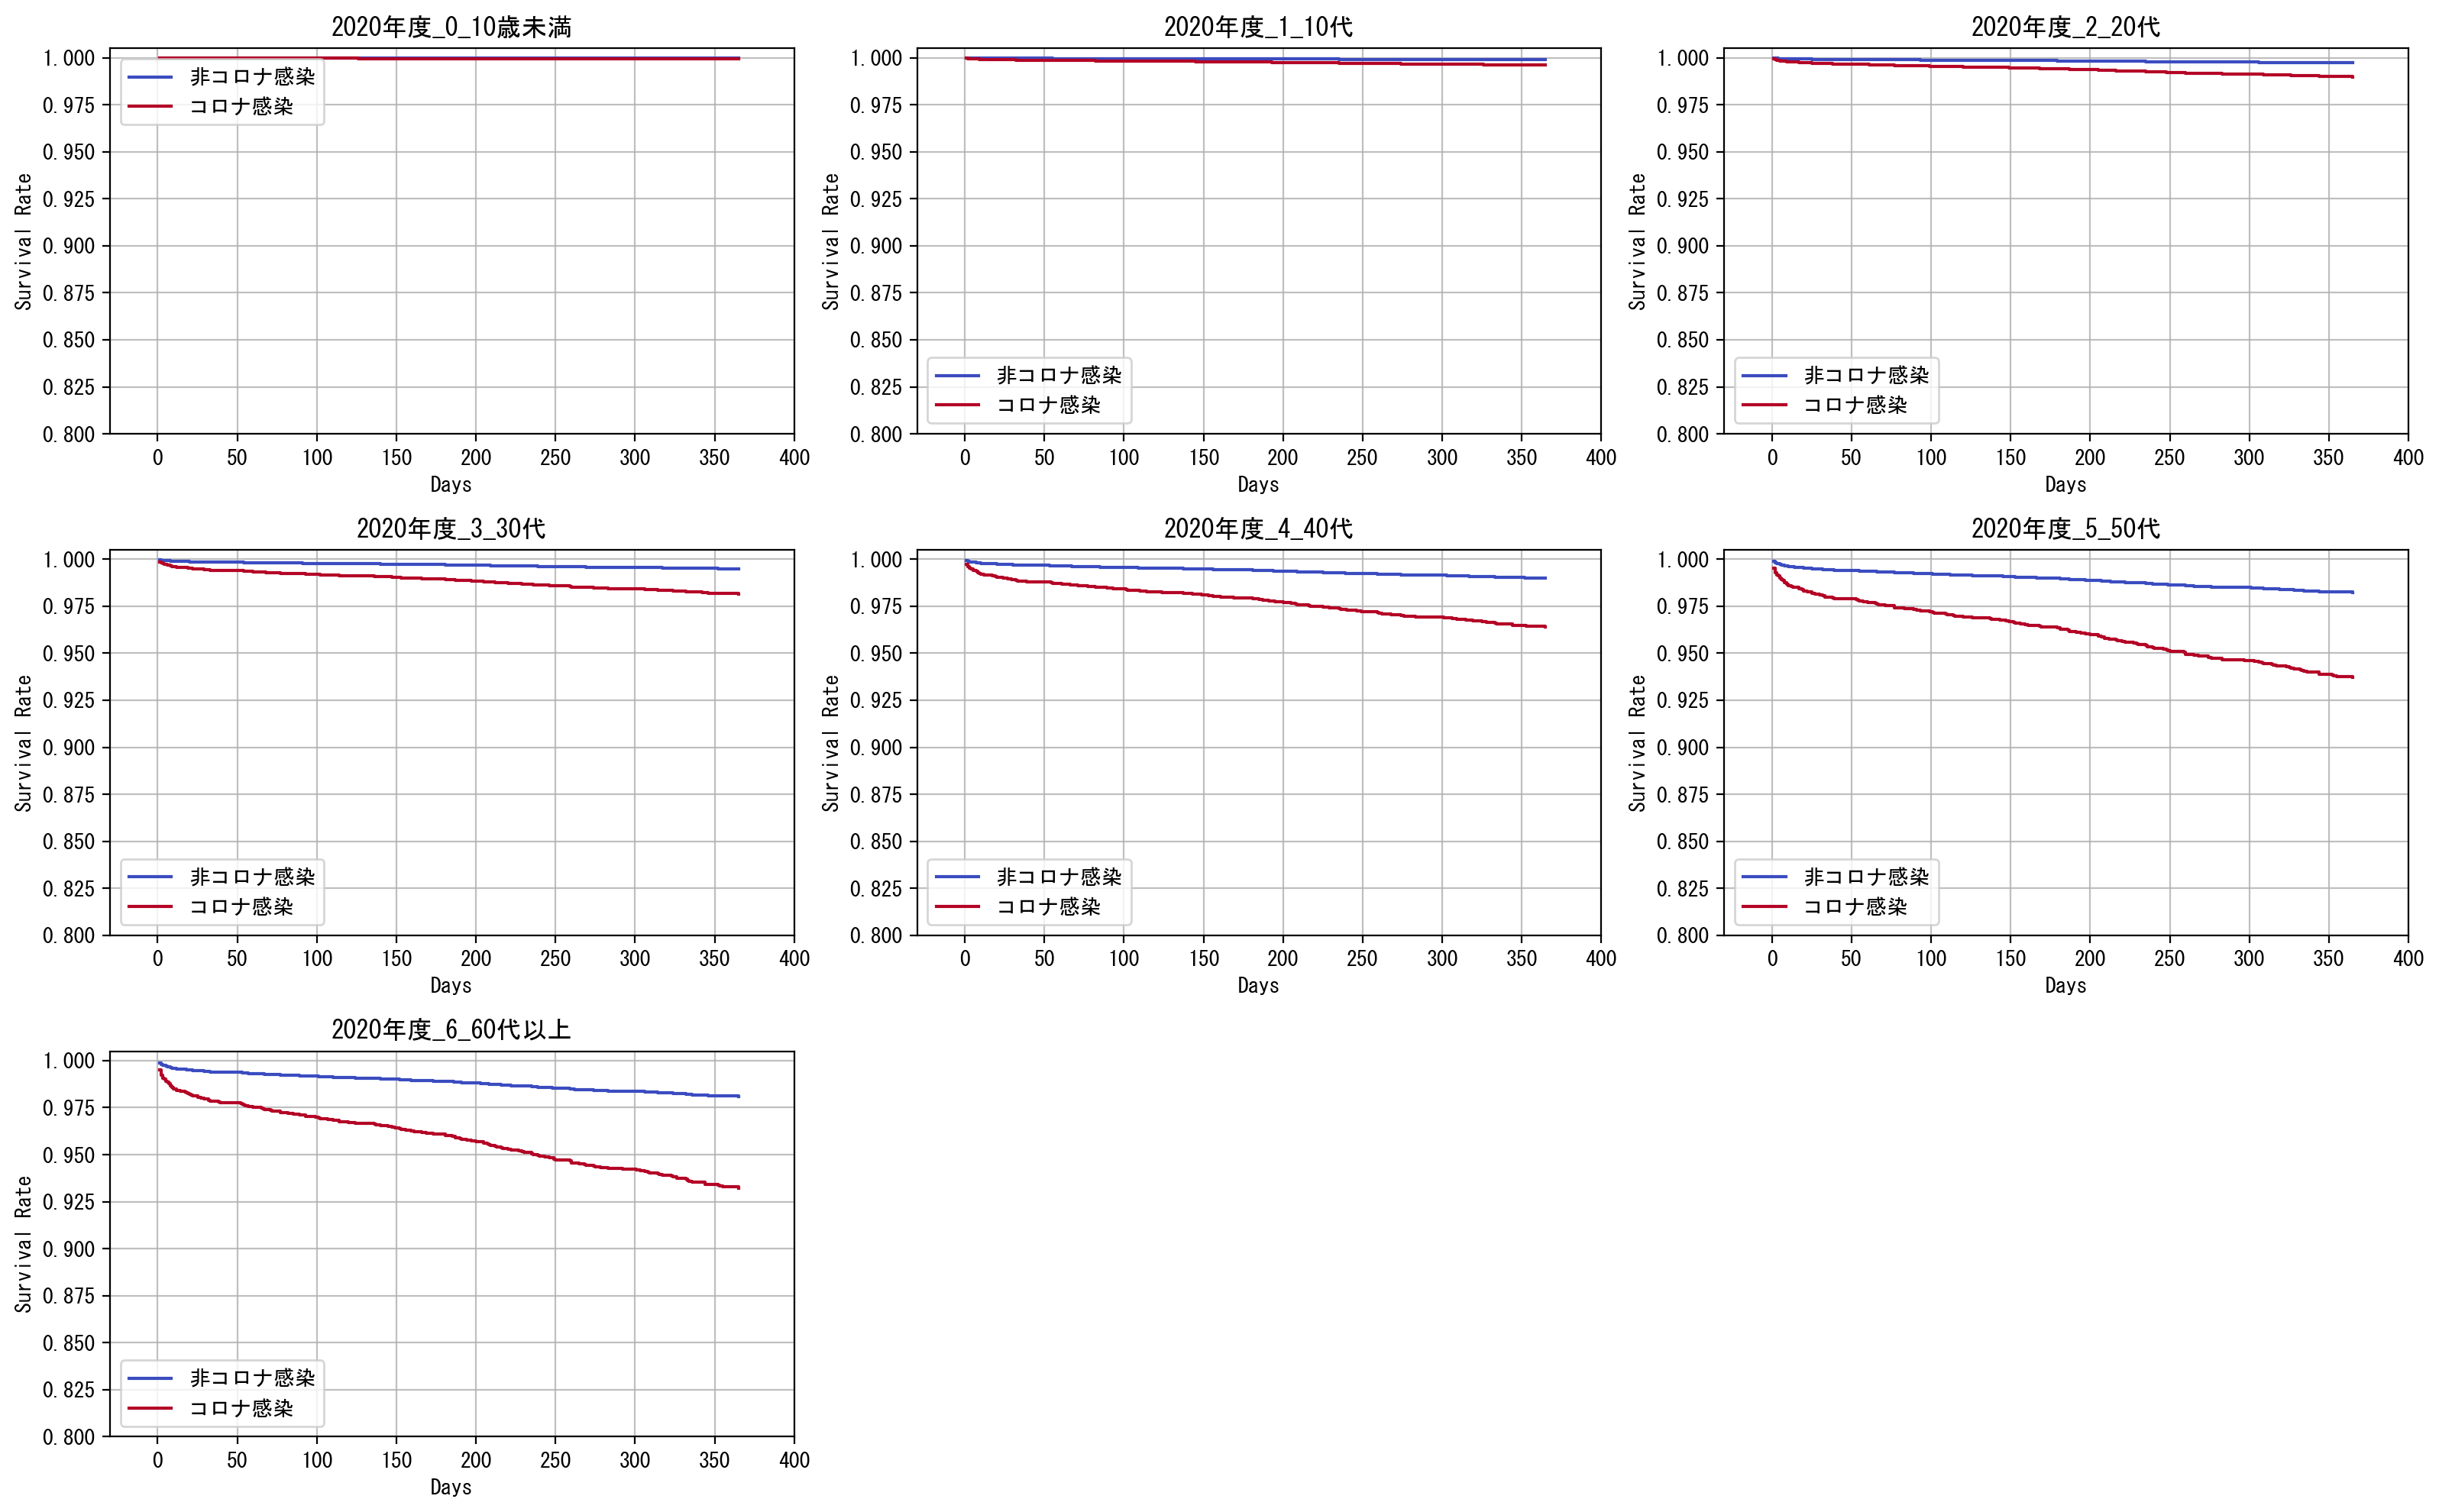

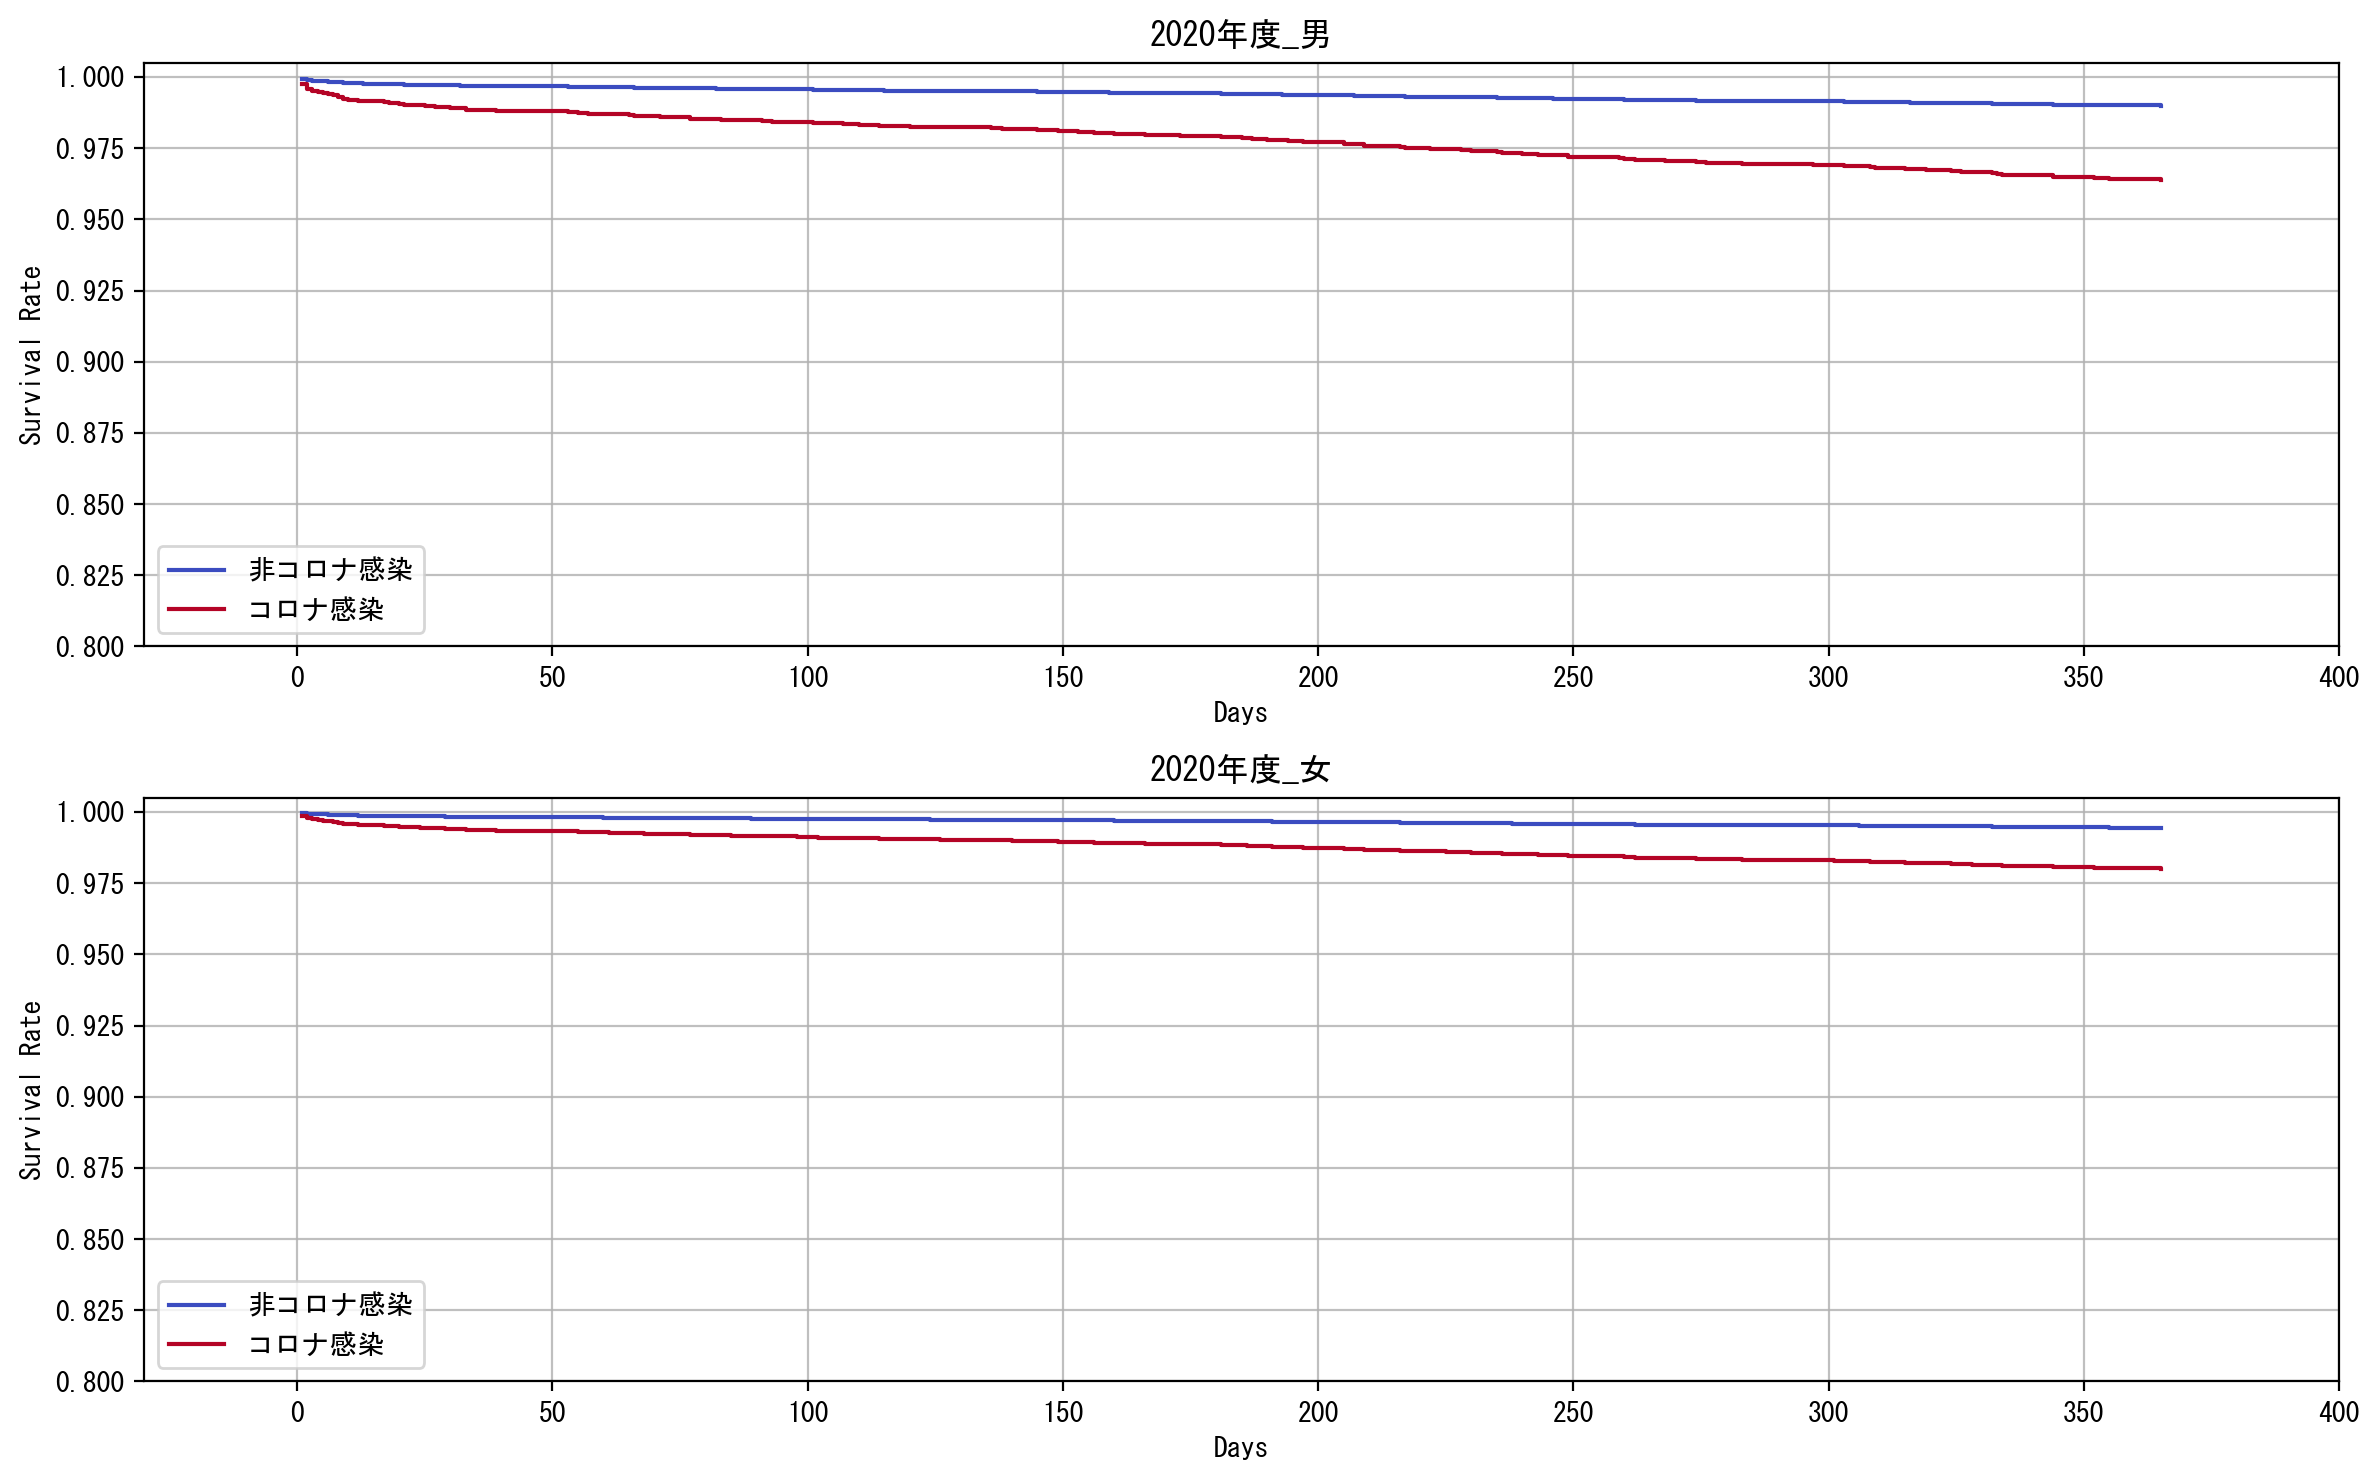

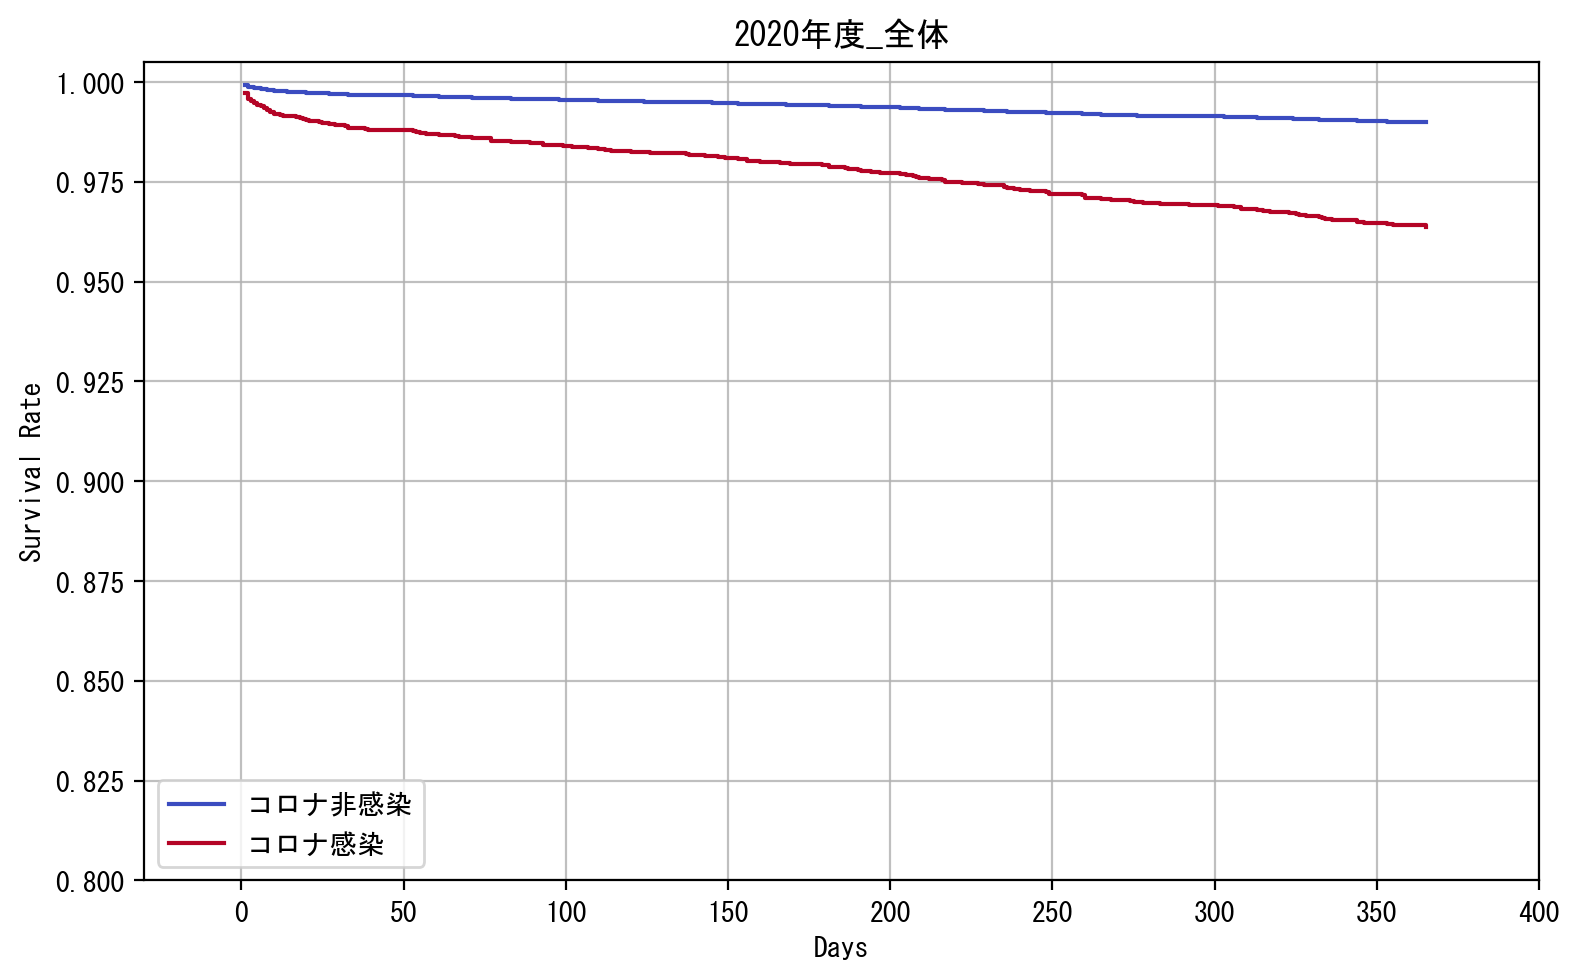

 20%|██        | 1/5 [00:03<00:15,  3.85s/it]c:\Users\matsuura\anaconda3\lib\site-packages\lifelines\utils\__init__.py:1122: ConvergenceWarning: Column age_kbn_0_10歳未満 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Diabetes_flag_1y'].astype(bool)
>>> print(df.loc[events, 'age_kbn_0_10歳未満'].var())
>>> print(df.loc[~events, 'age_kbn_0_10歳未満'].var())

A very low variance means that the column age_kbn_0_10歳未満 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
c:\Users\matsuura\anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.399. This may imply non-

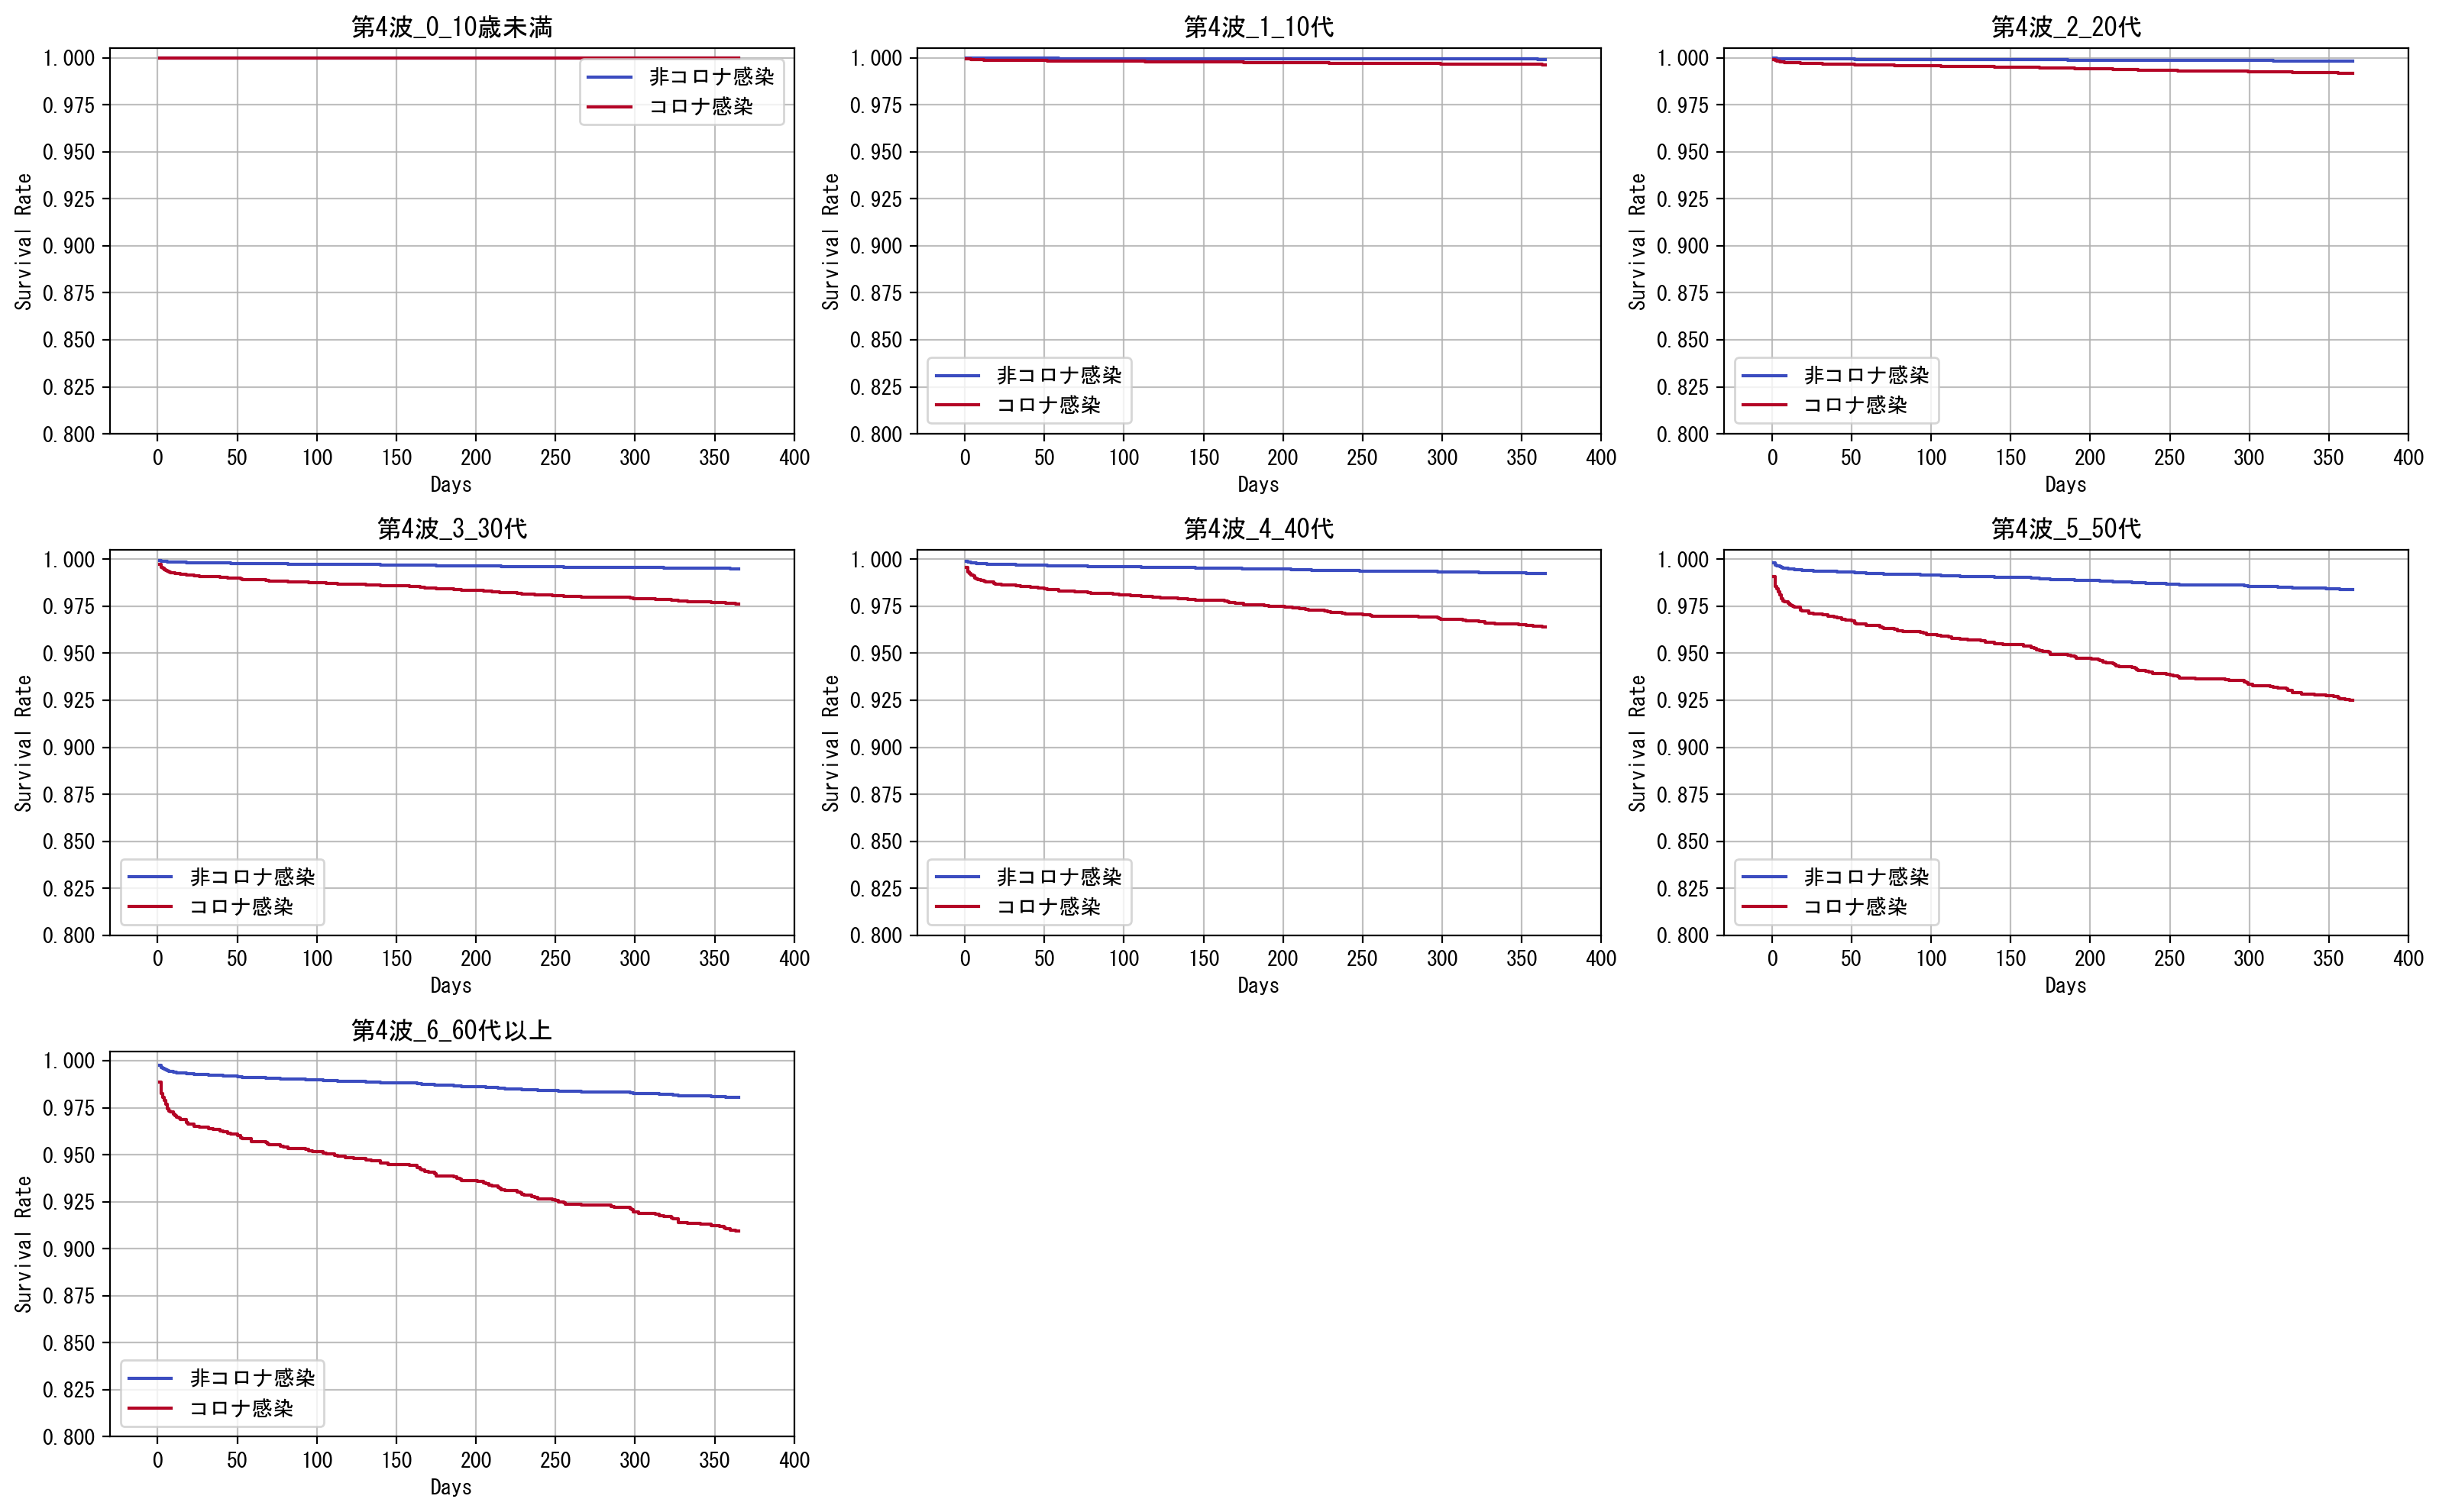

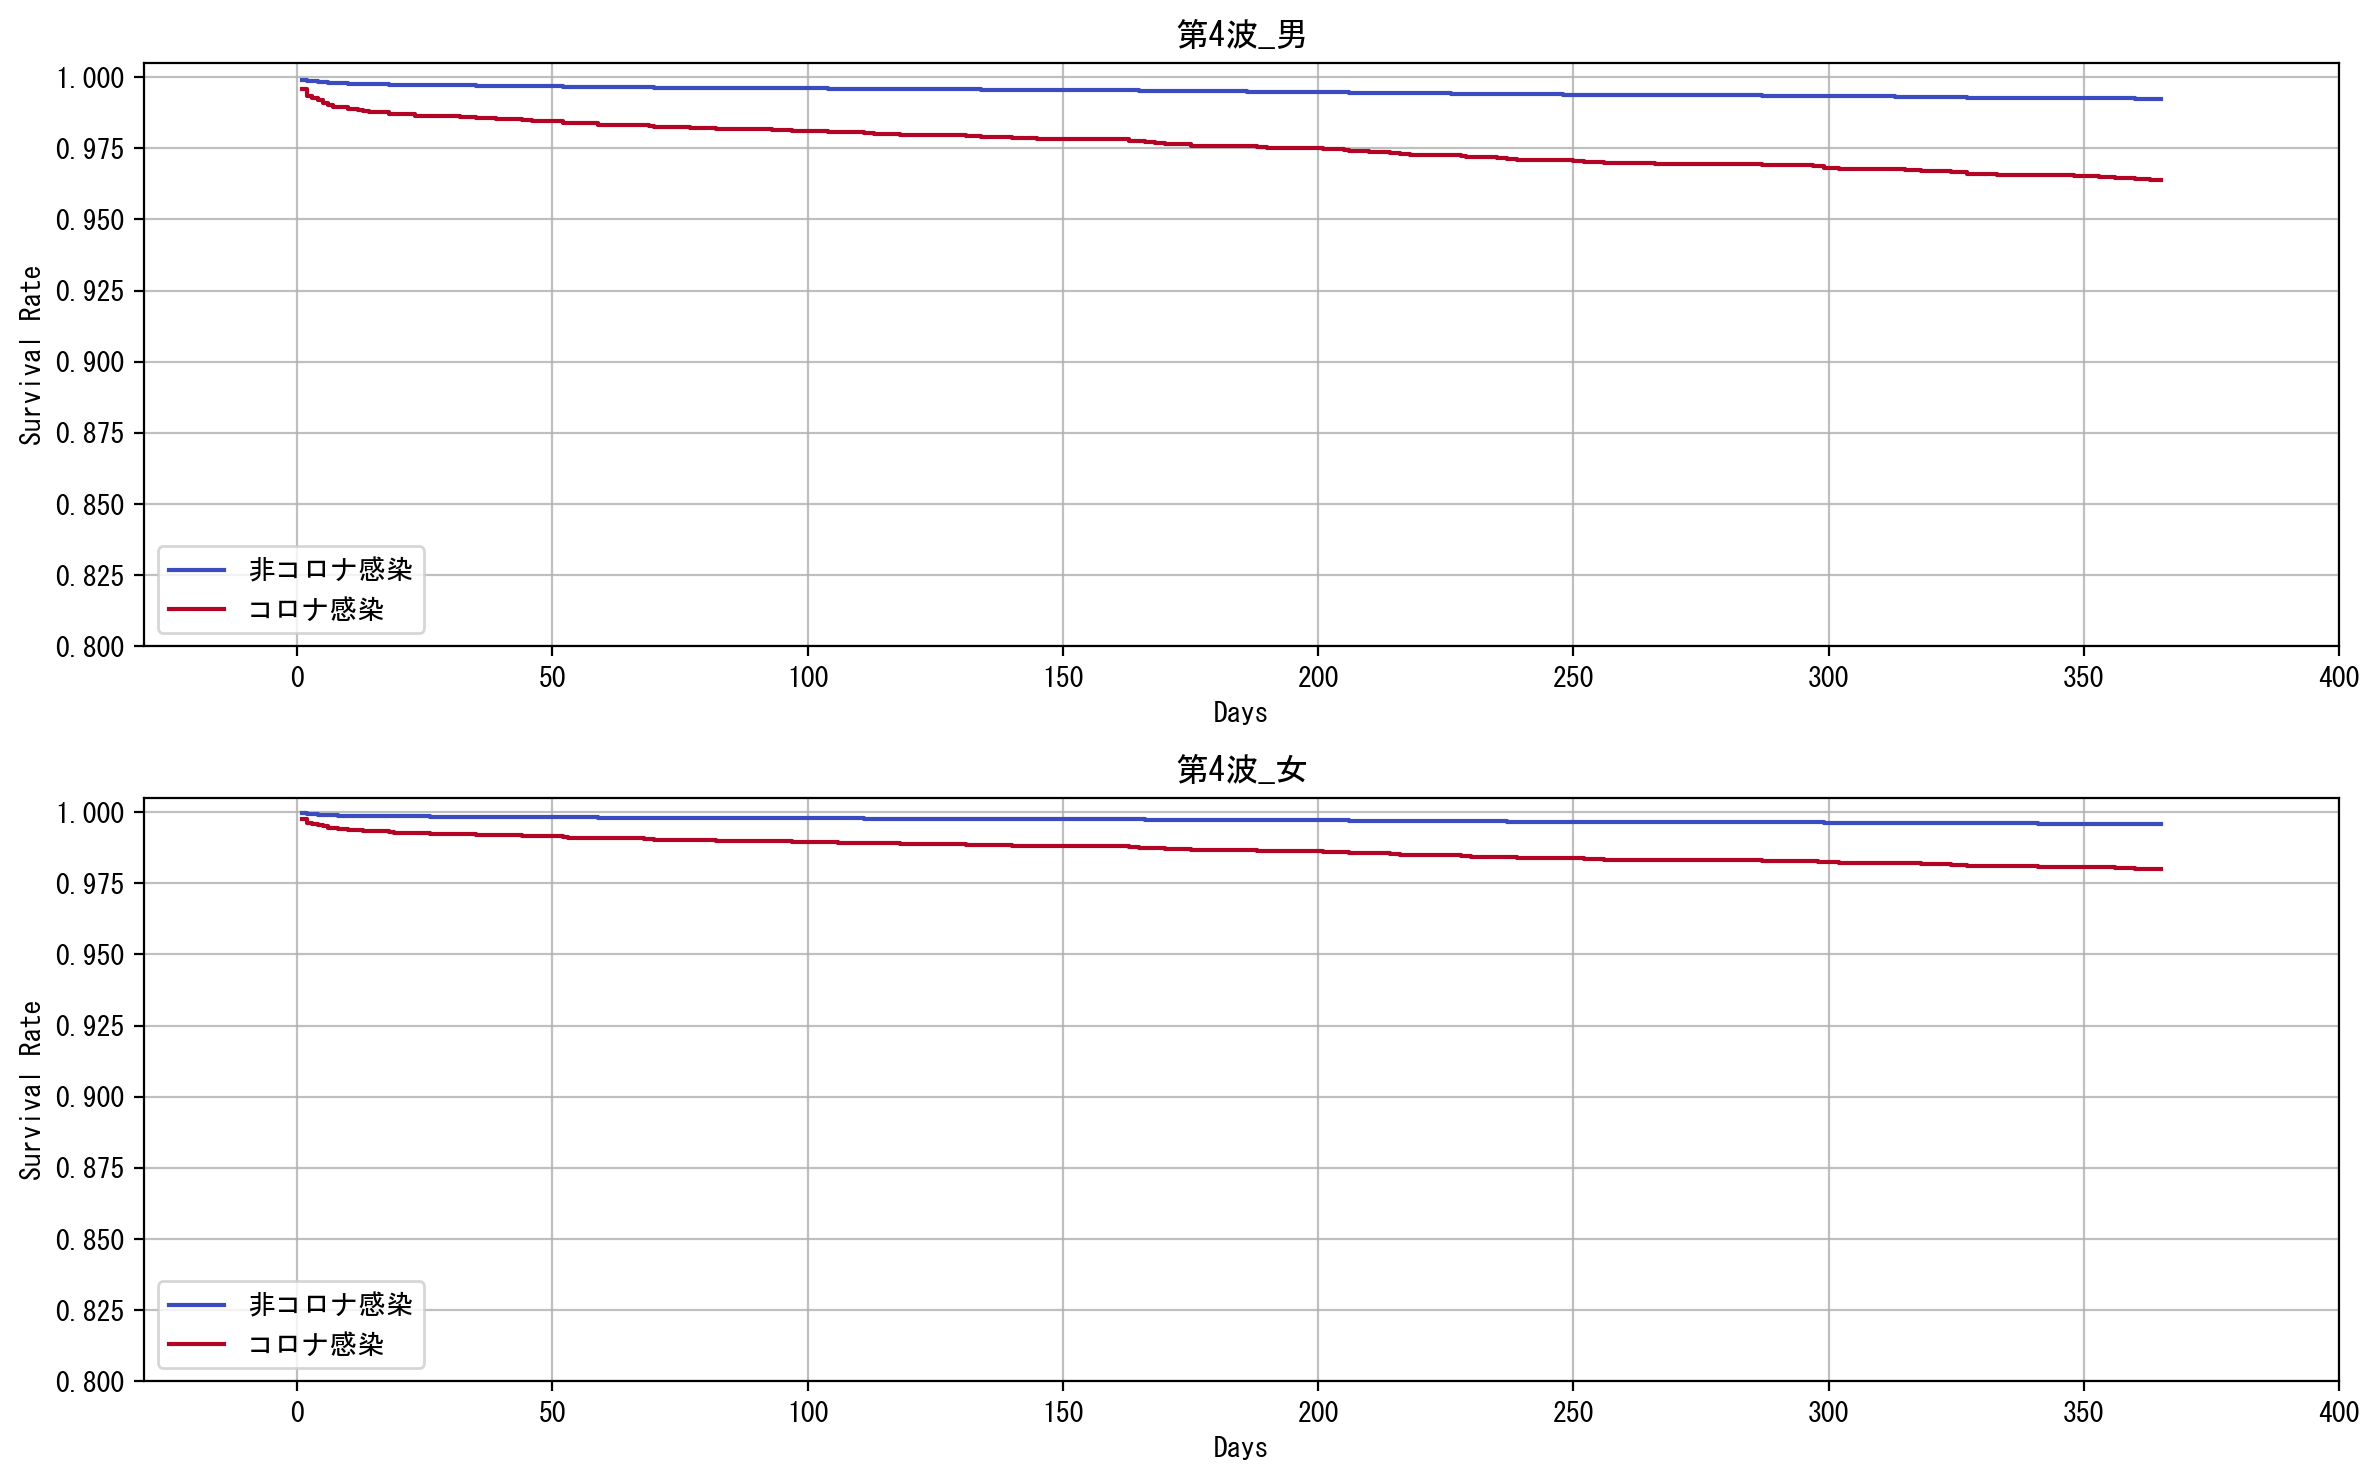

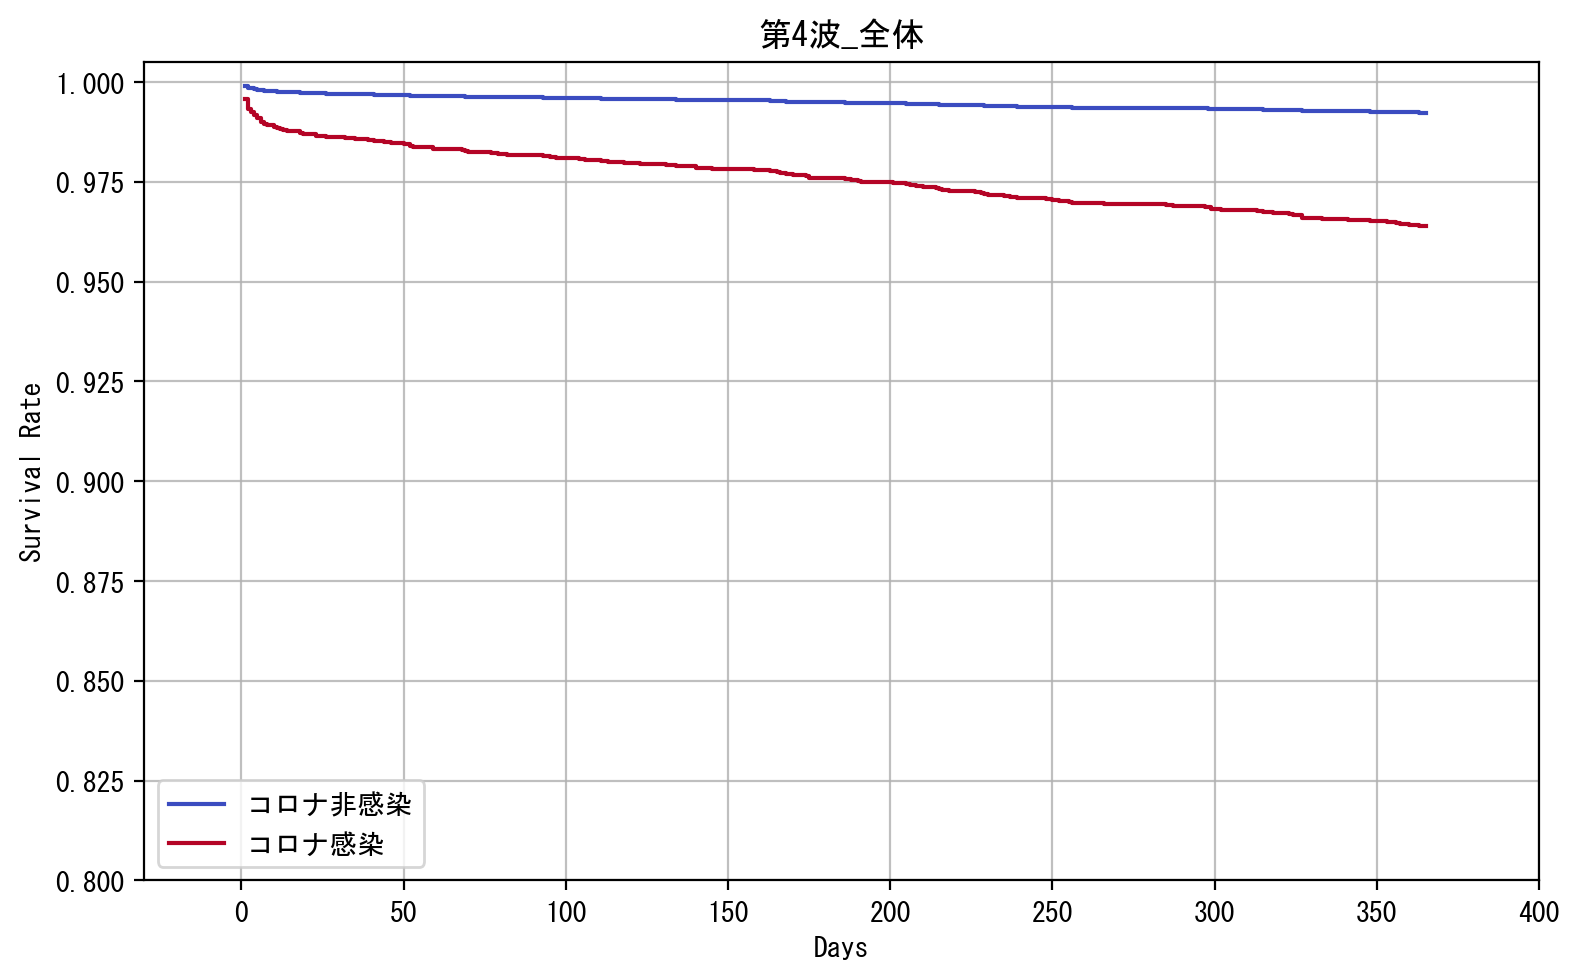

 40%|████      | 2/5 [00:07<00:10,  3.44s/it]c:\Users\matsuura\anaconda3\lib\site-packages\lifelines\utils\__init__.py:1122: ConvergenceWarning: Column pref_nm_02_青森 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Diabetes_flag_1y'].astype(bool)
>>> print(df.loc[events, 'pref_nm_02_青森'].var())
>>> print(df.loc[~events, 'pref_nm_02_青森'].var())

A very low variance means that the column pref_nm_02_青森 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
c:\Users\matsuura\anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.146. This may imply non-unique s

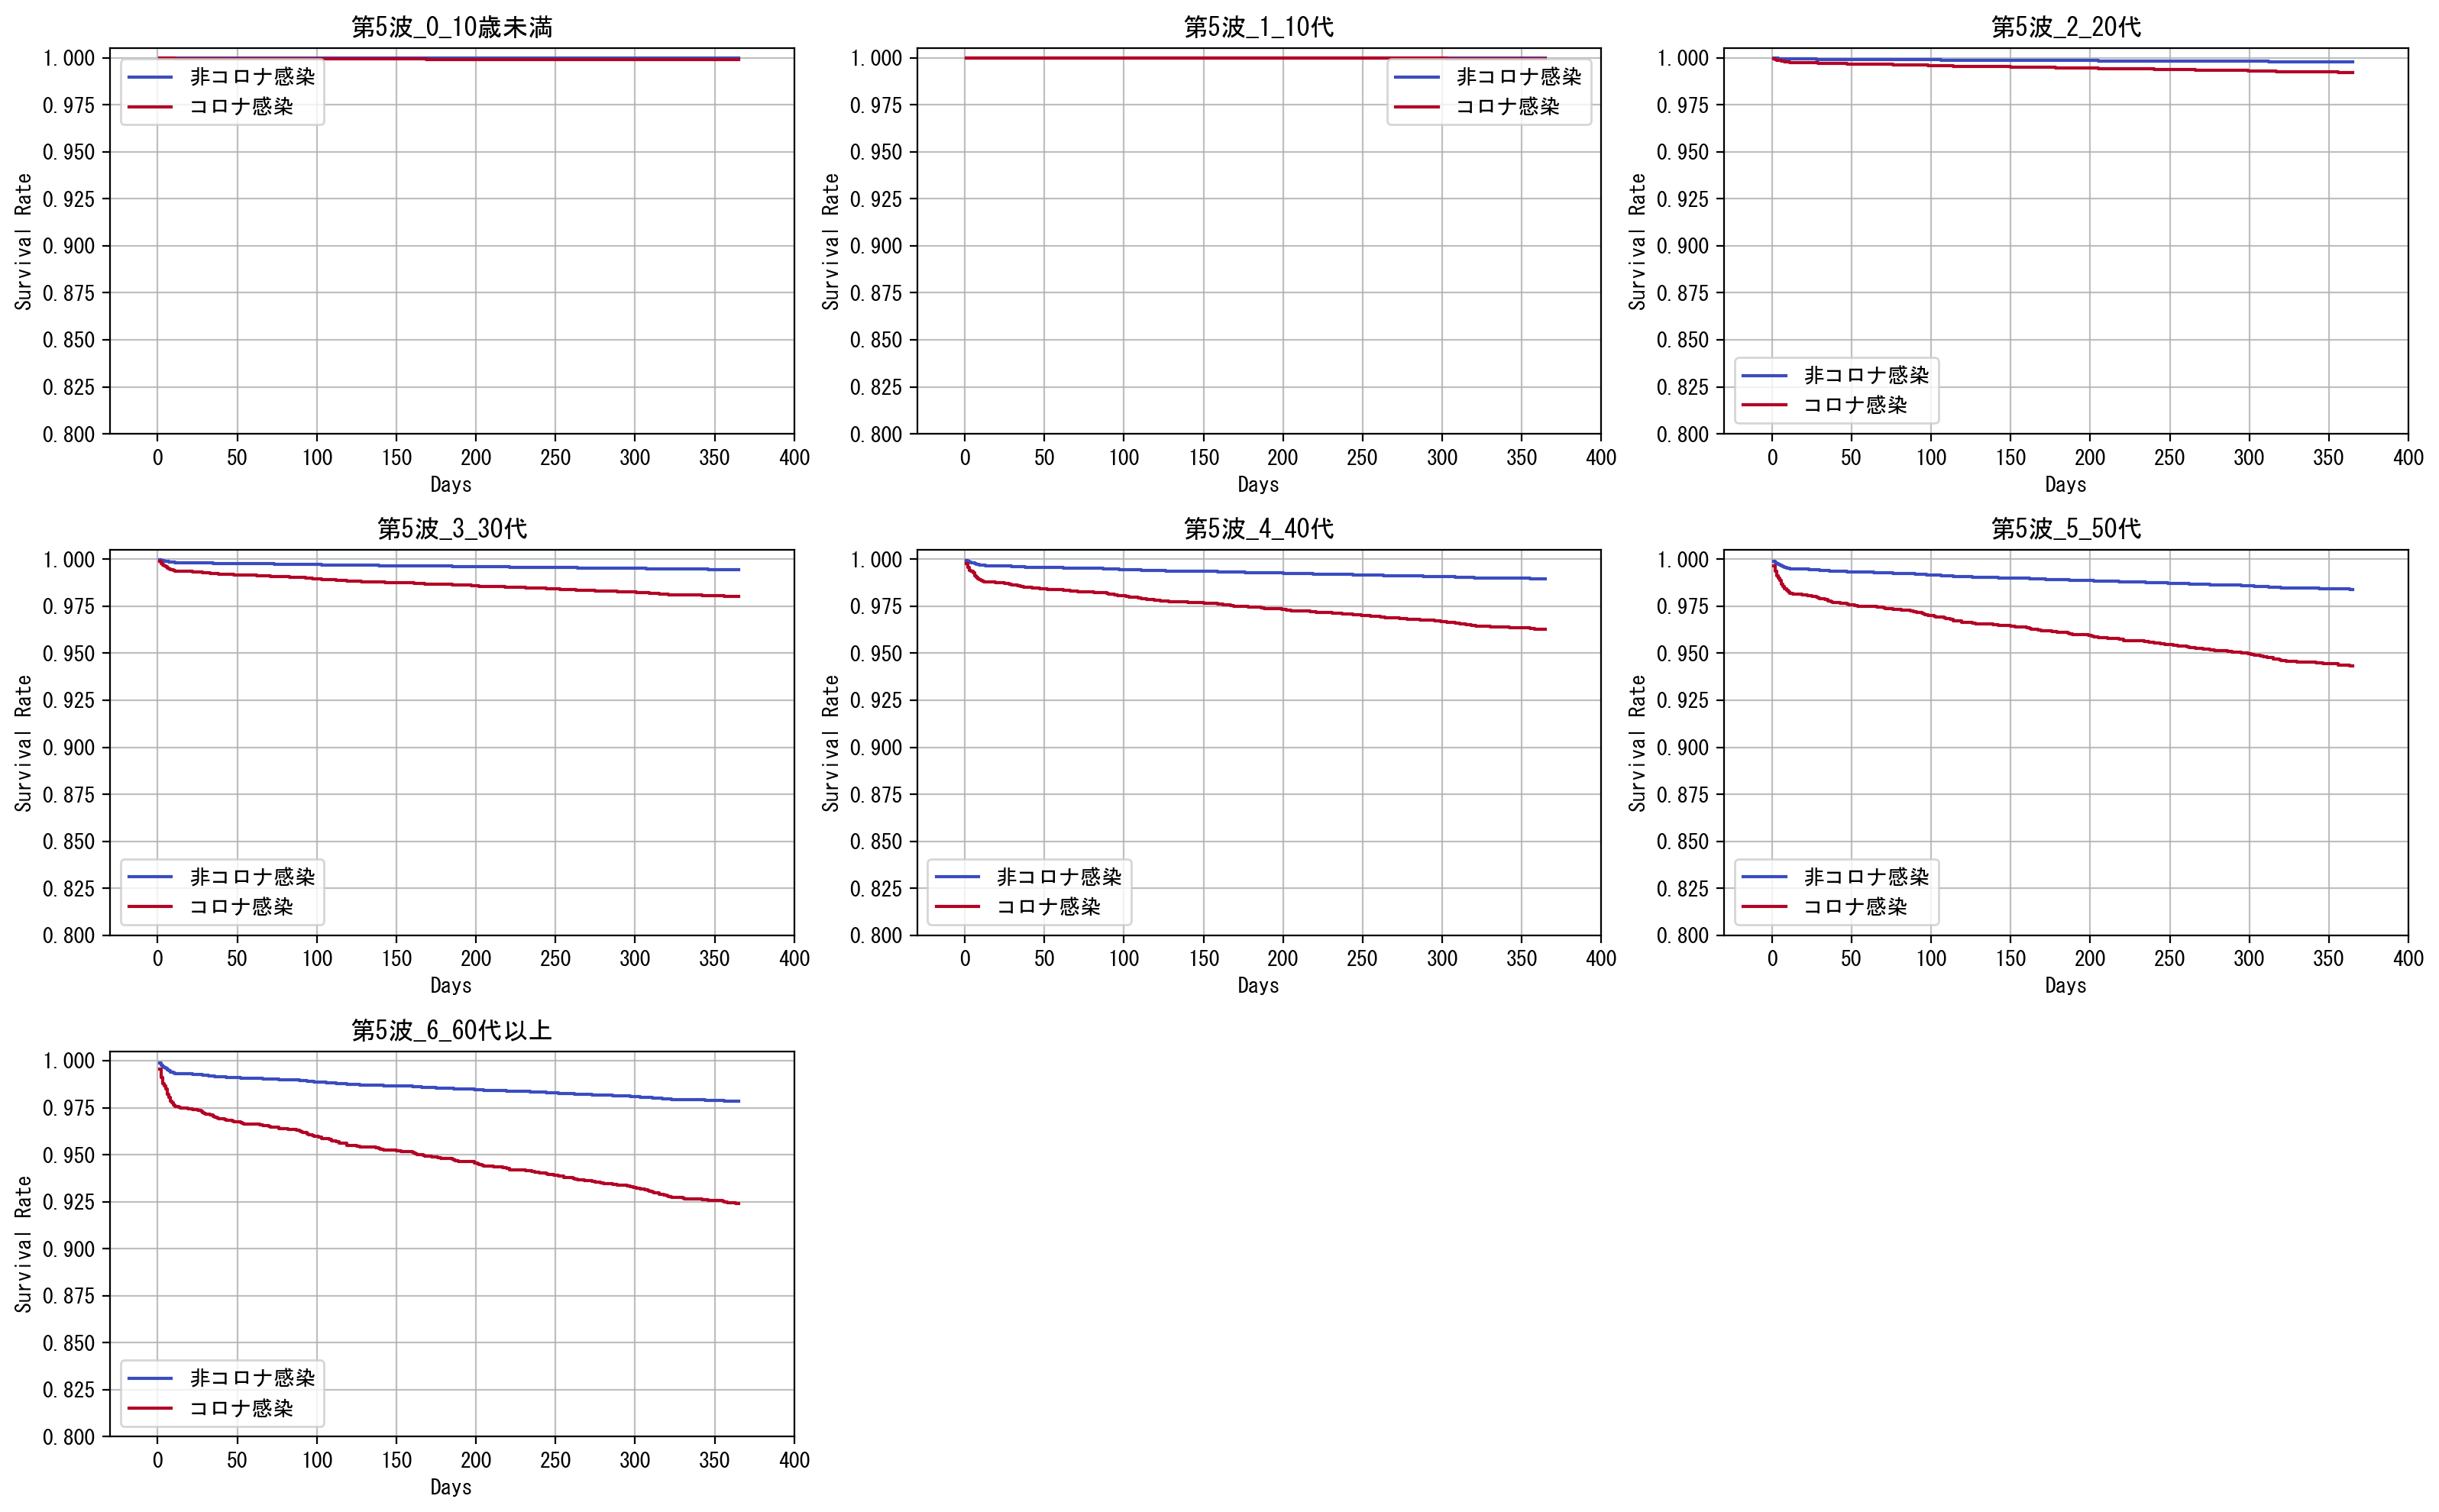

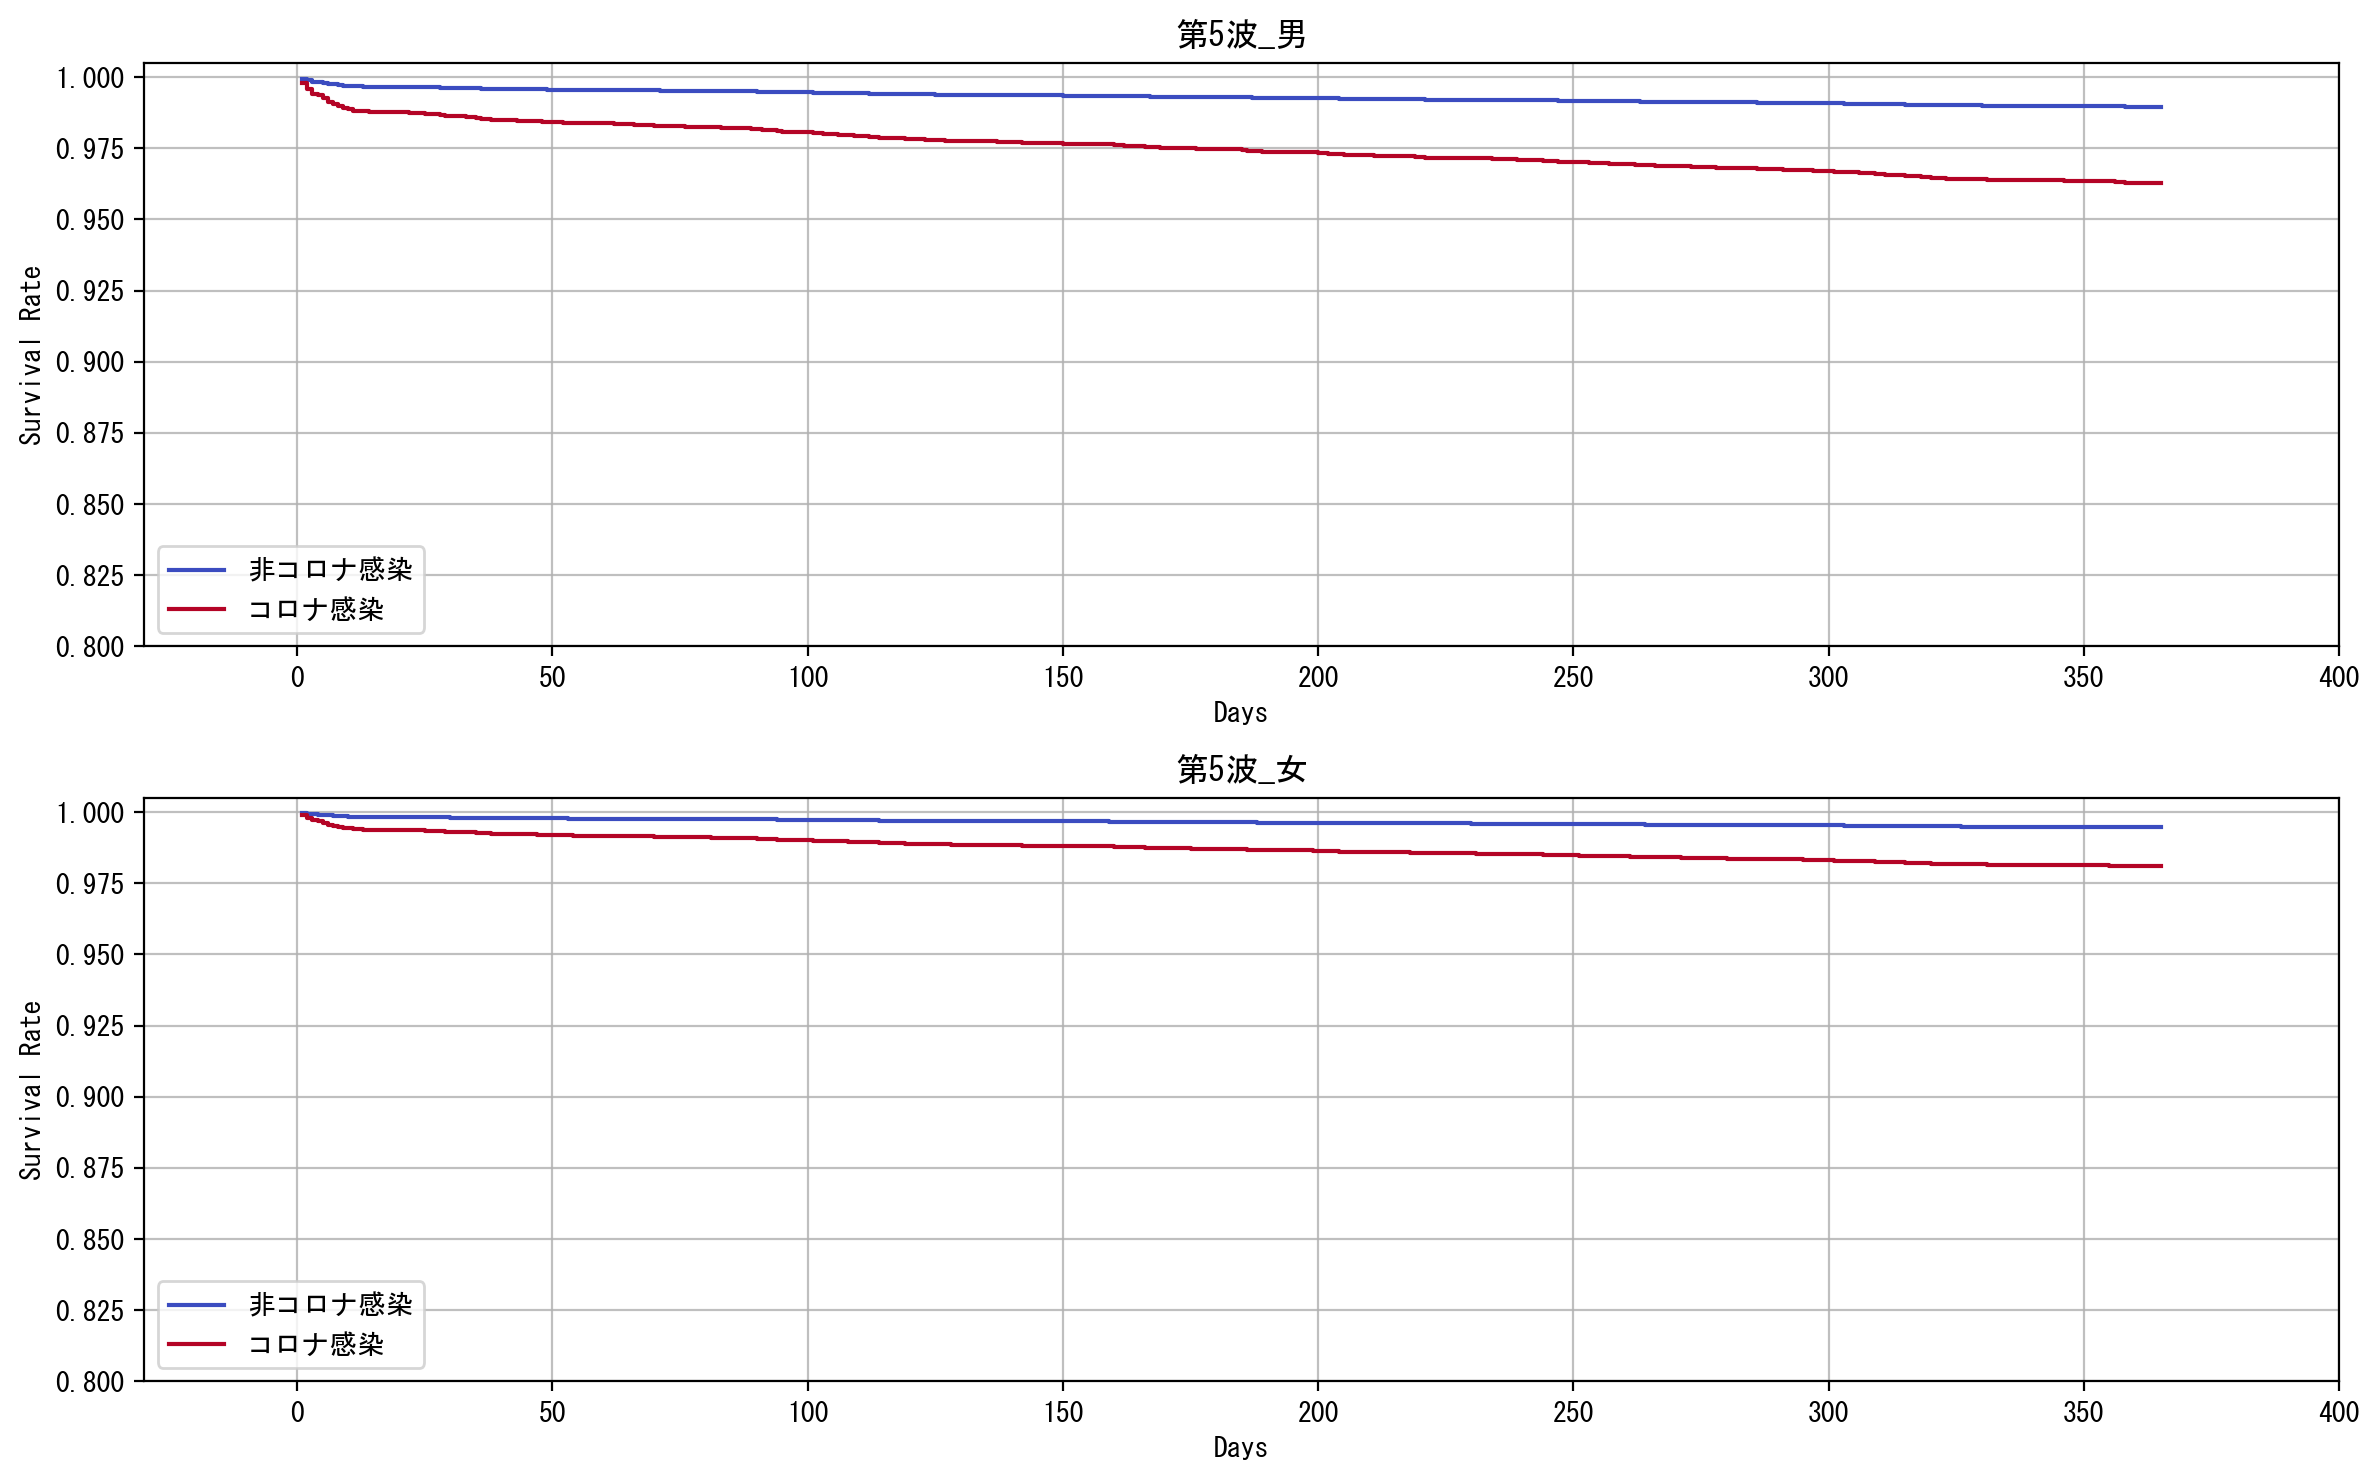

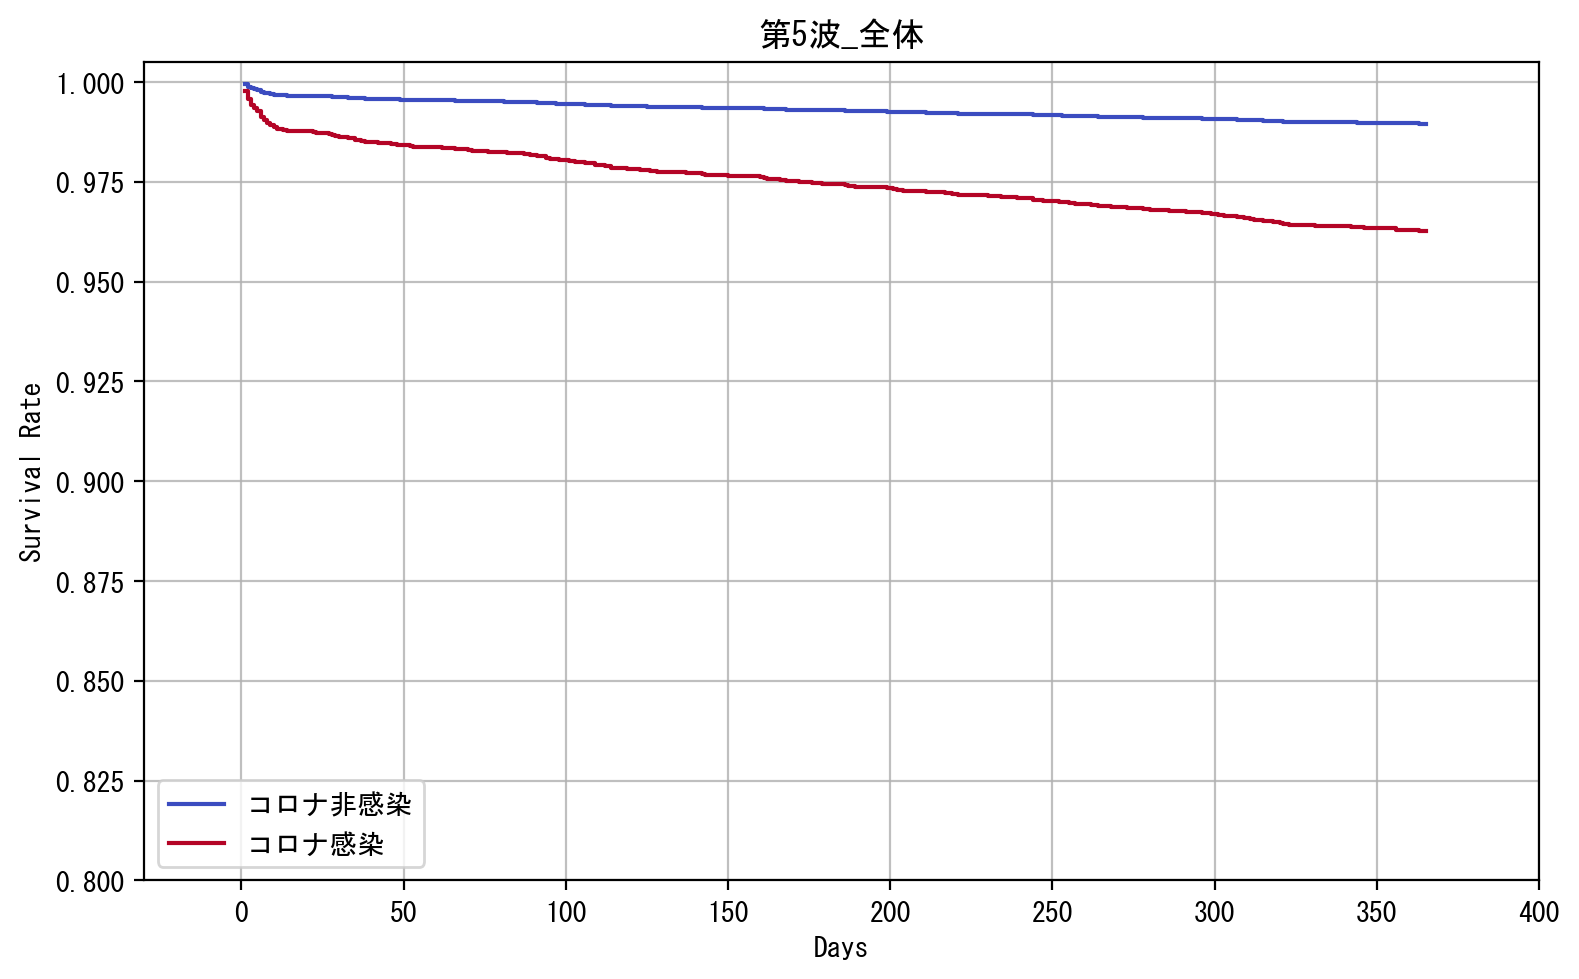

 60%|██████    | 3/5 [00:10<00:06,  3.49s/it]

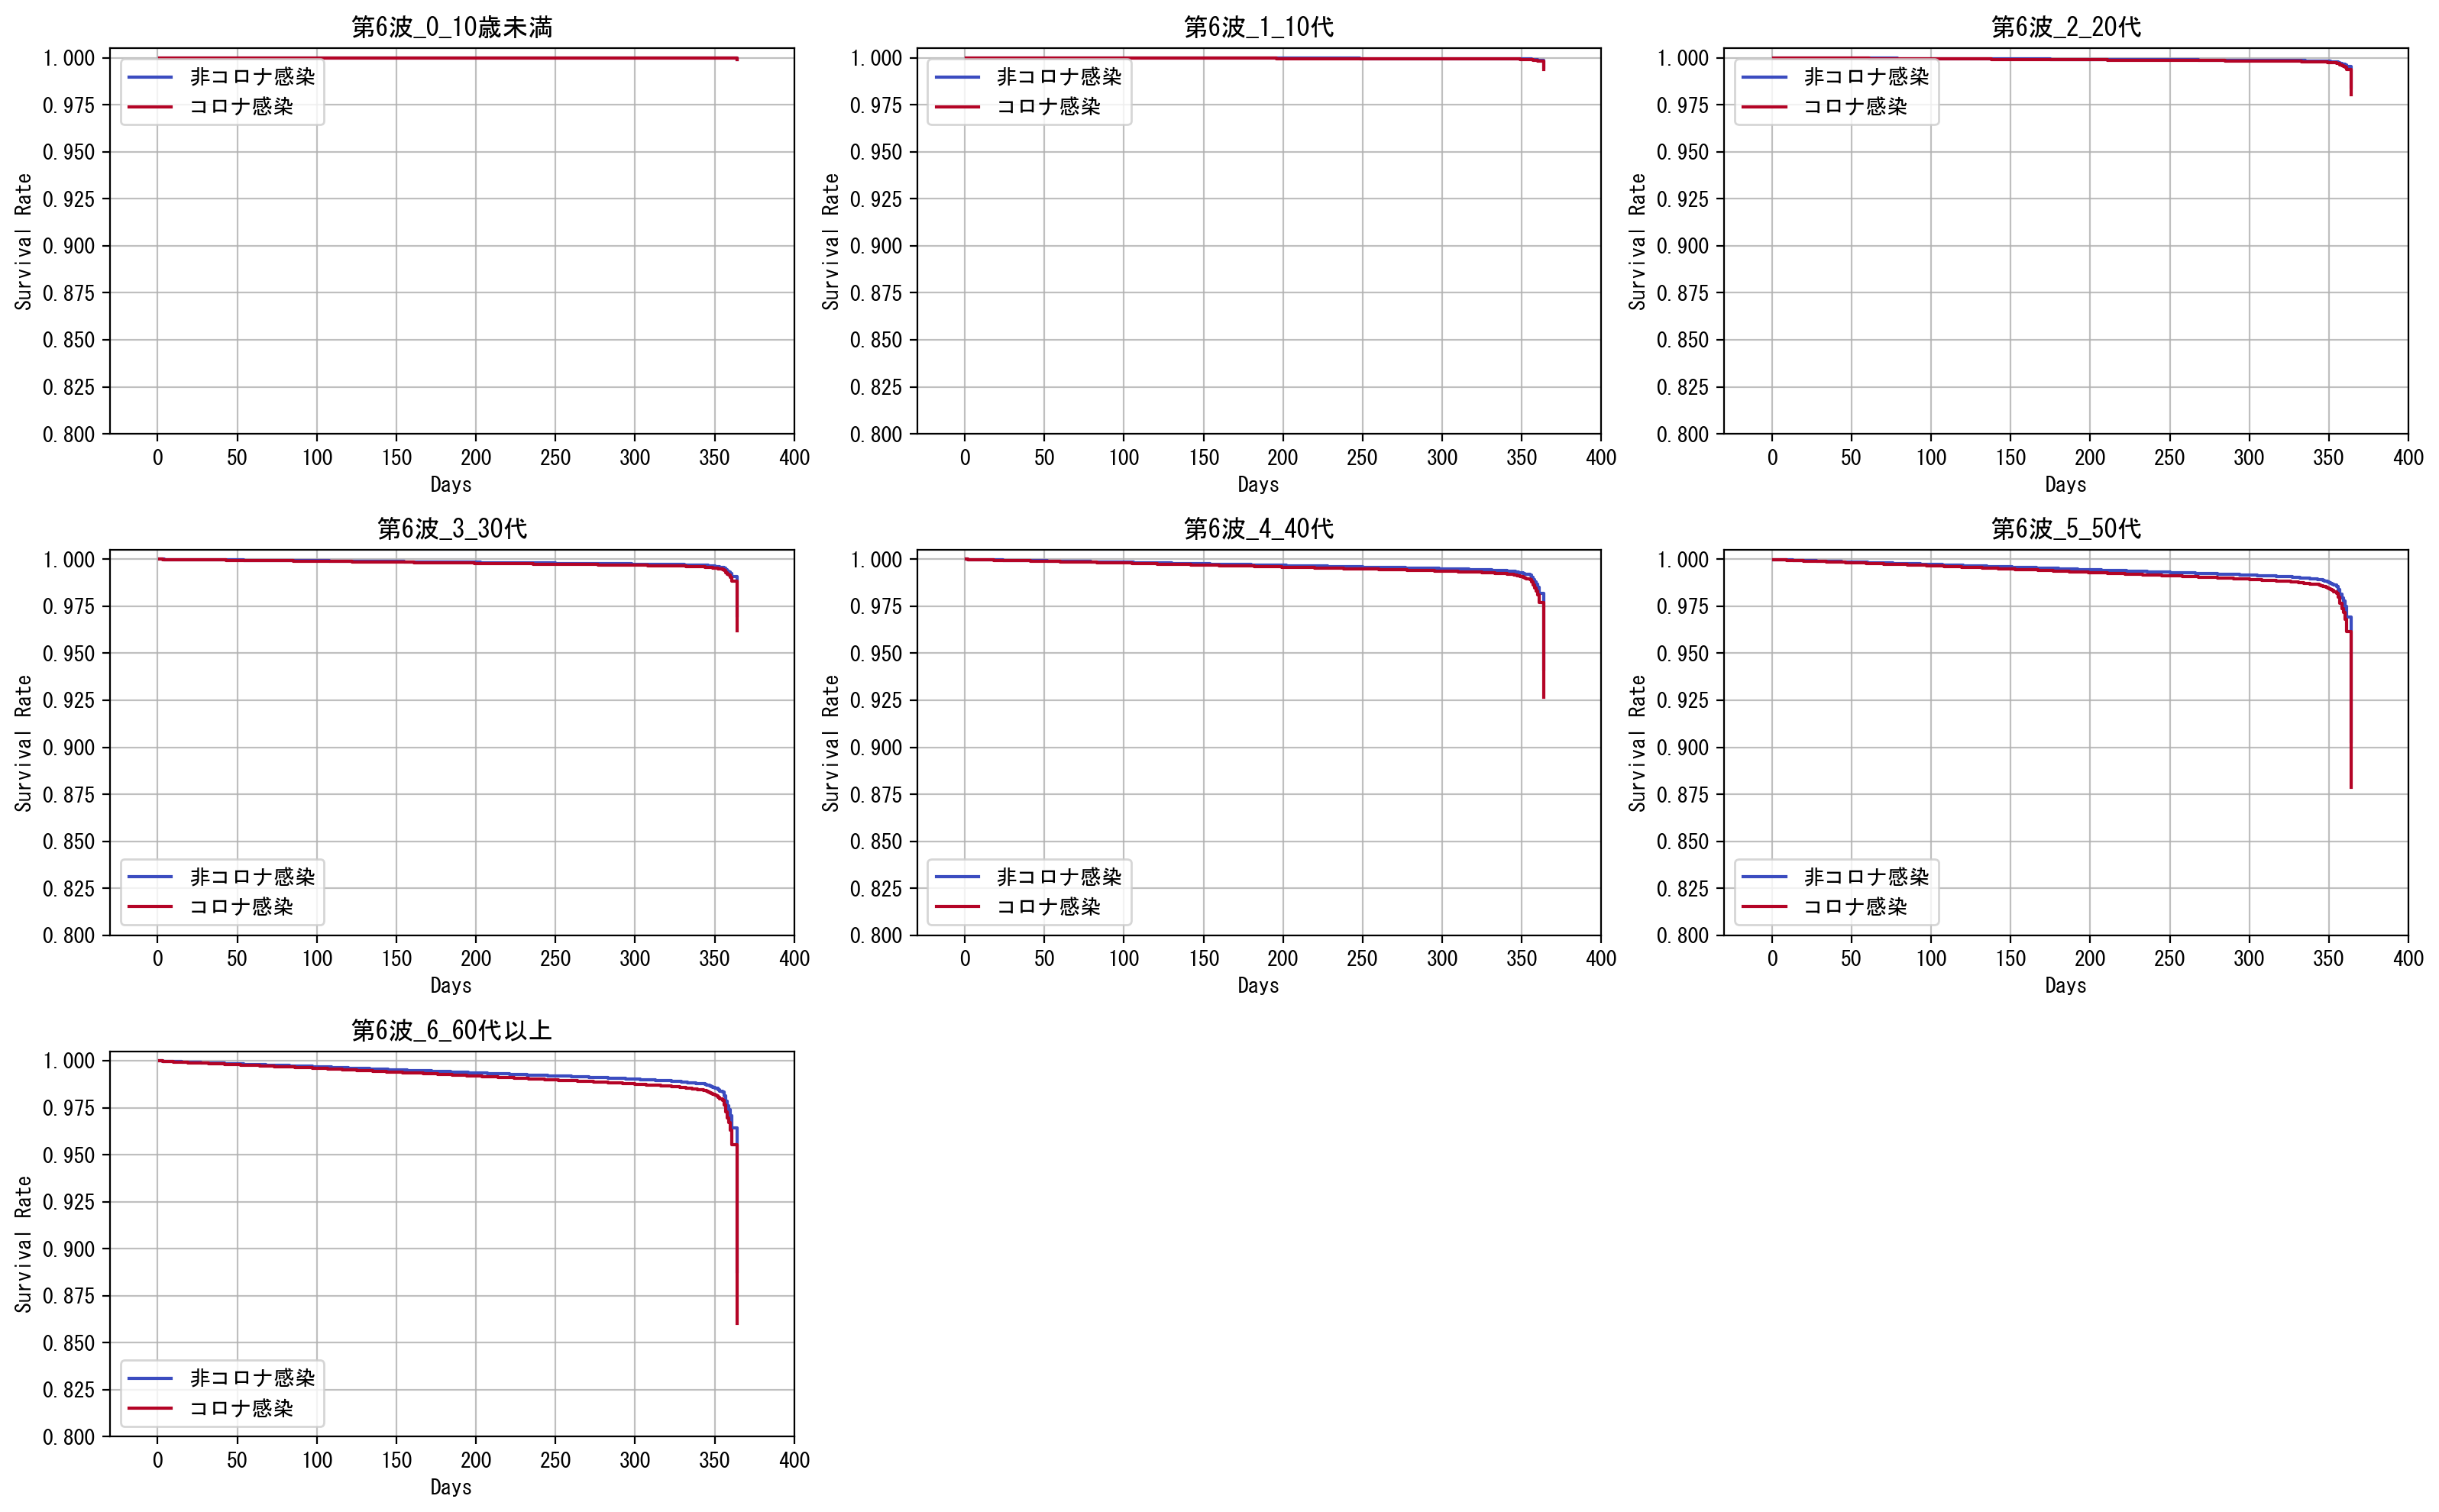

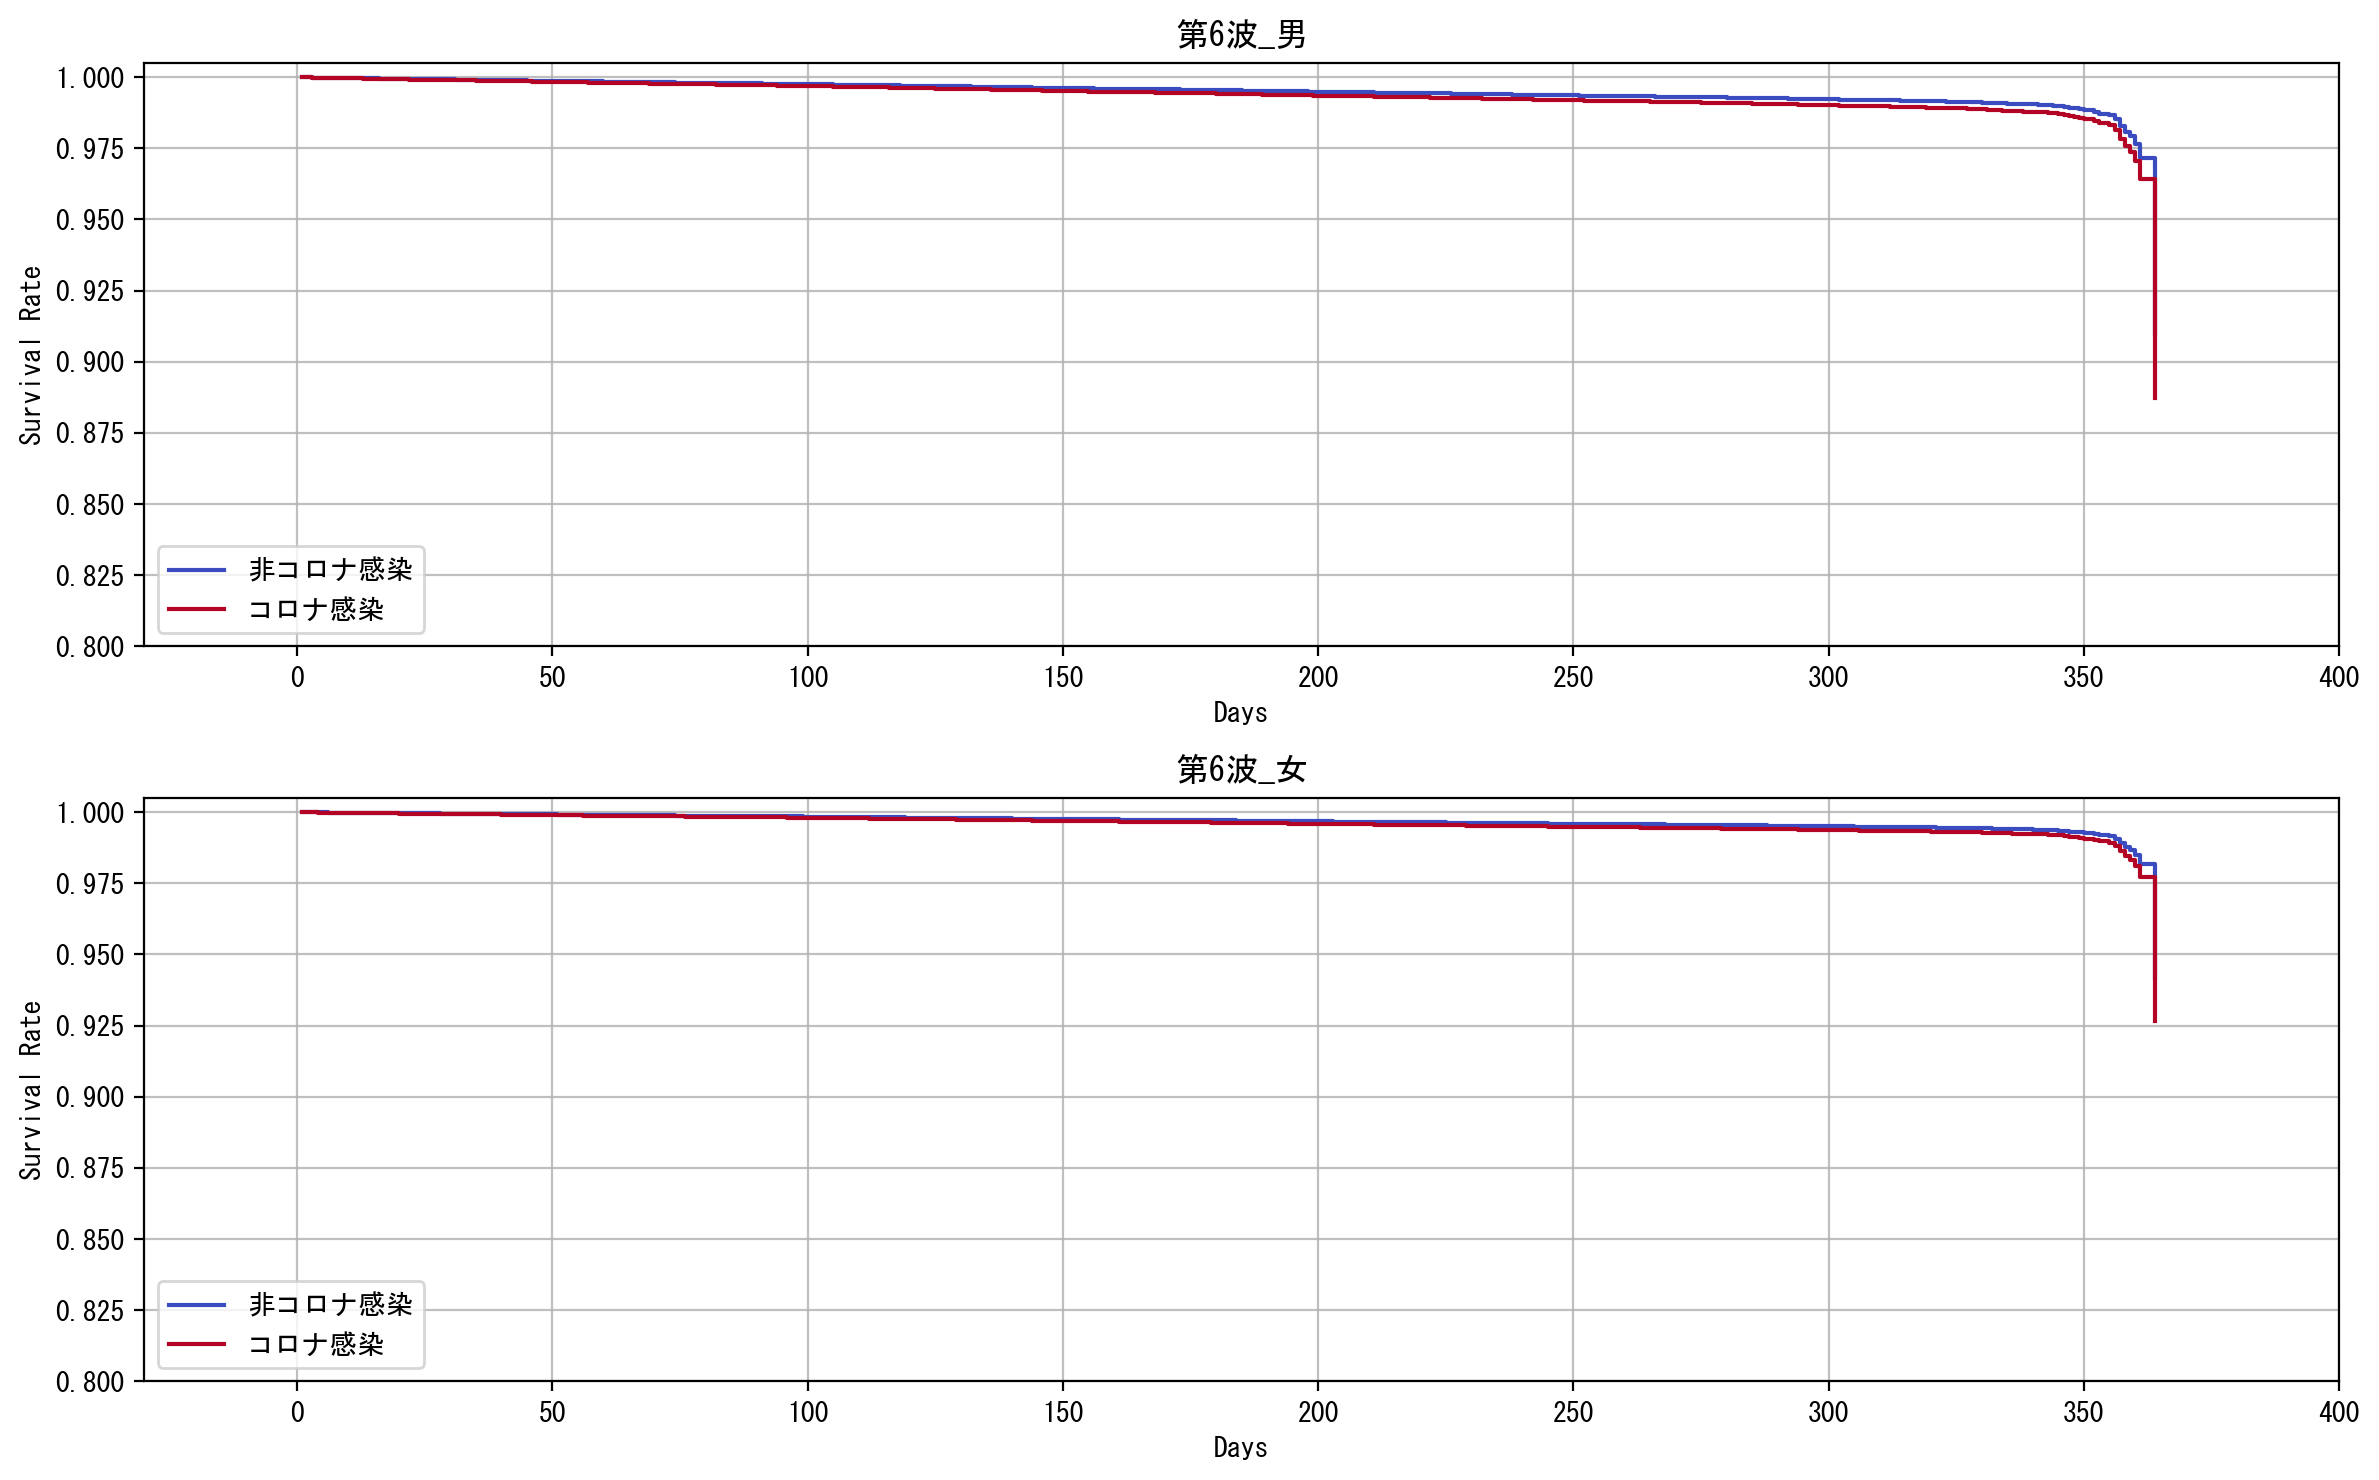

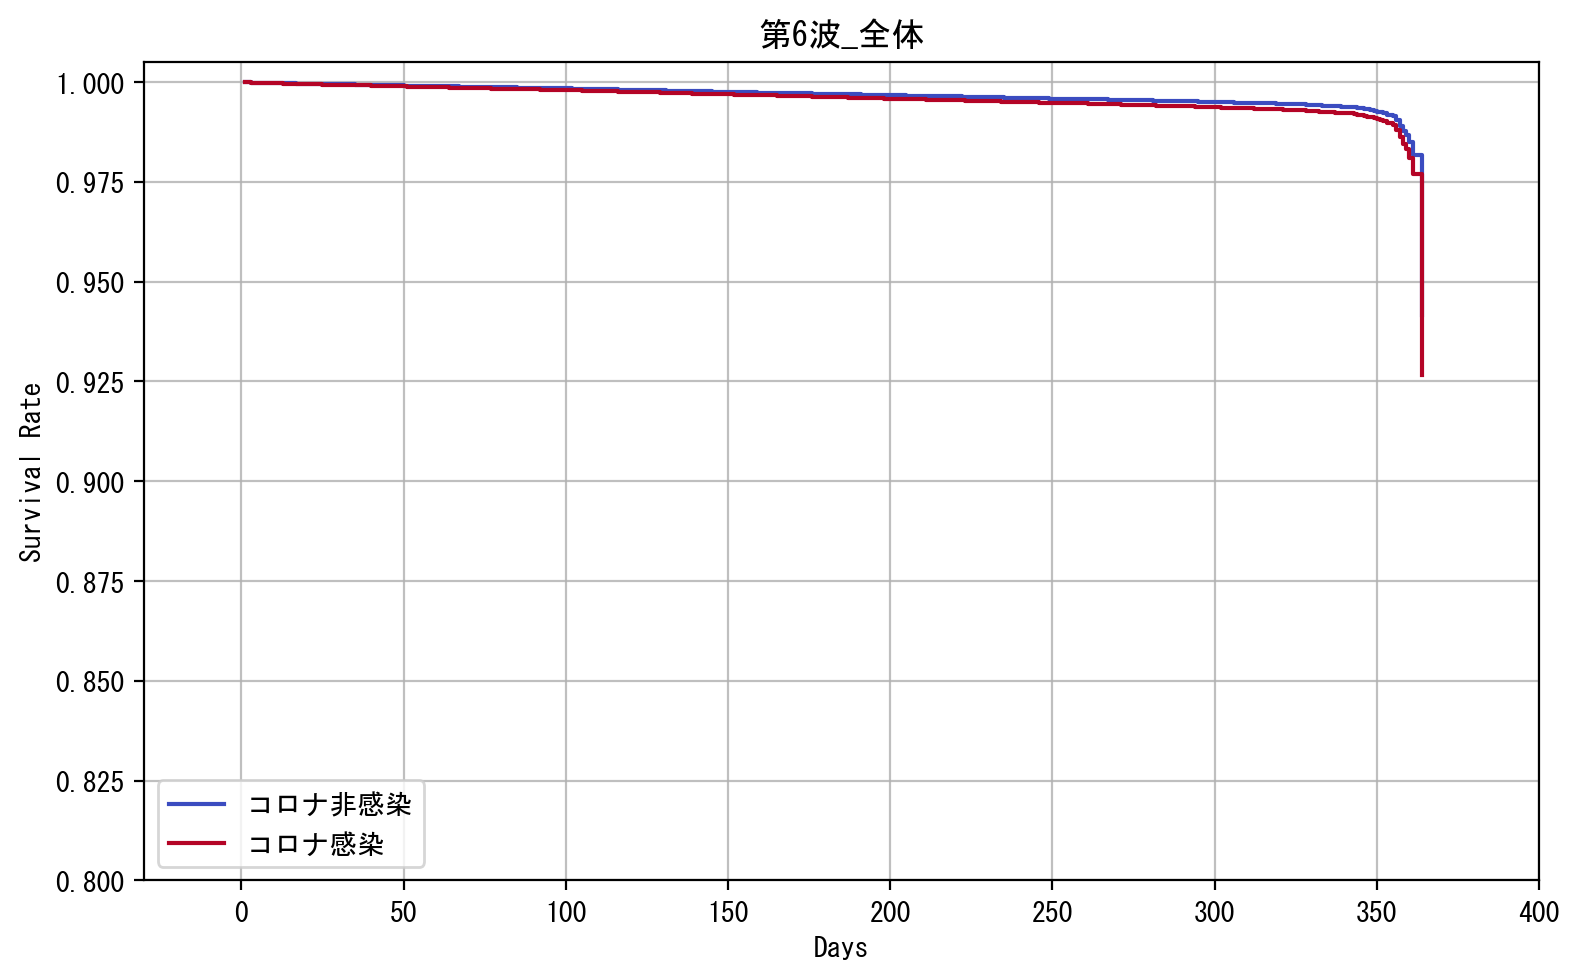

 80%|████████  | 4/5 [00:20<00:06,  6.13s/it]

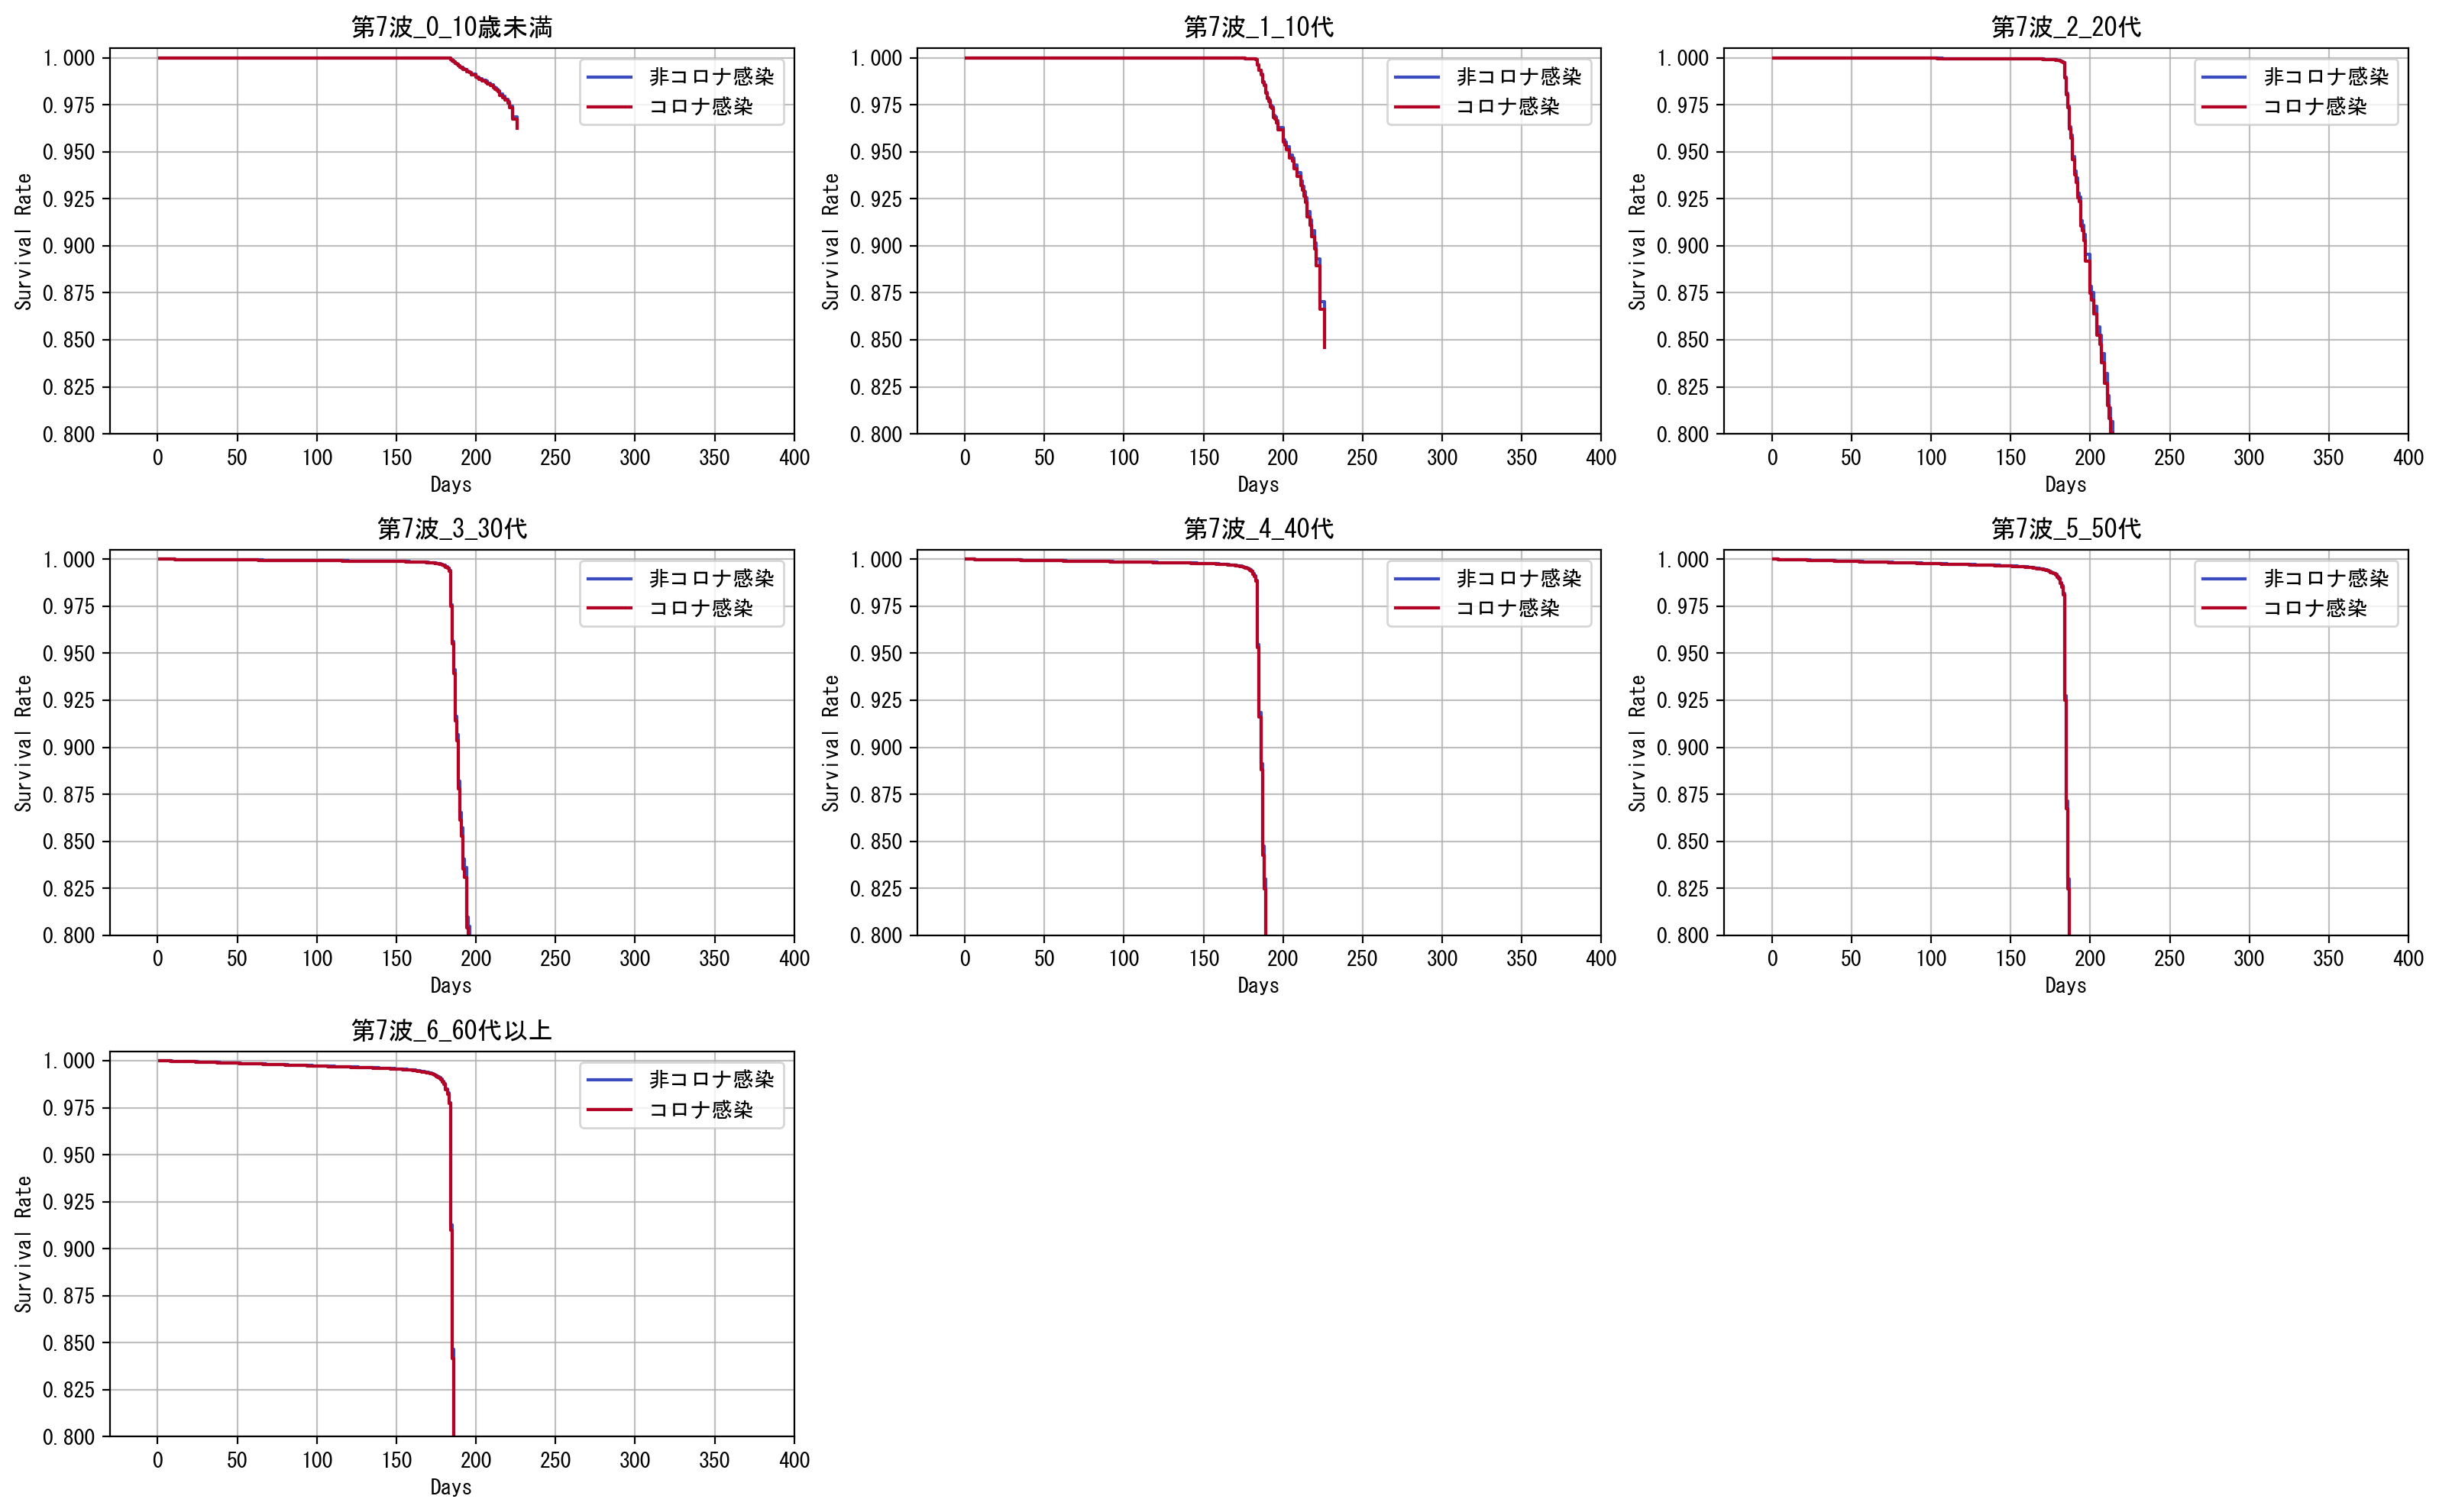

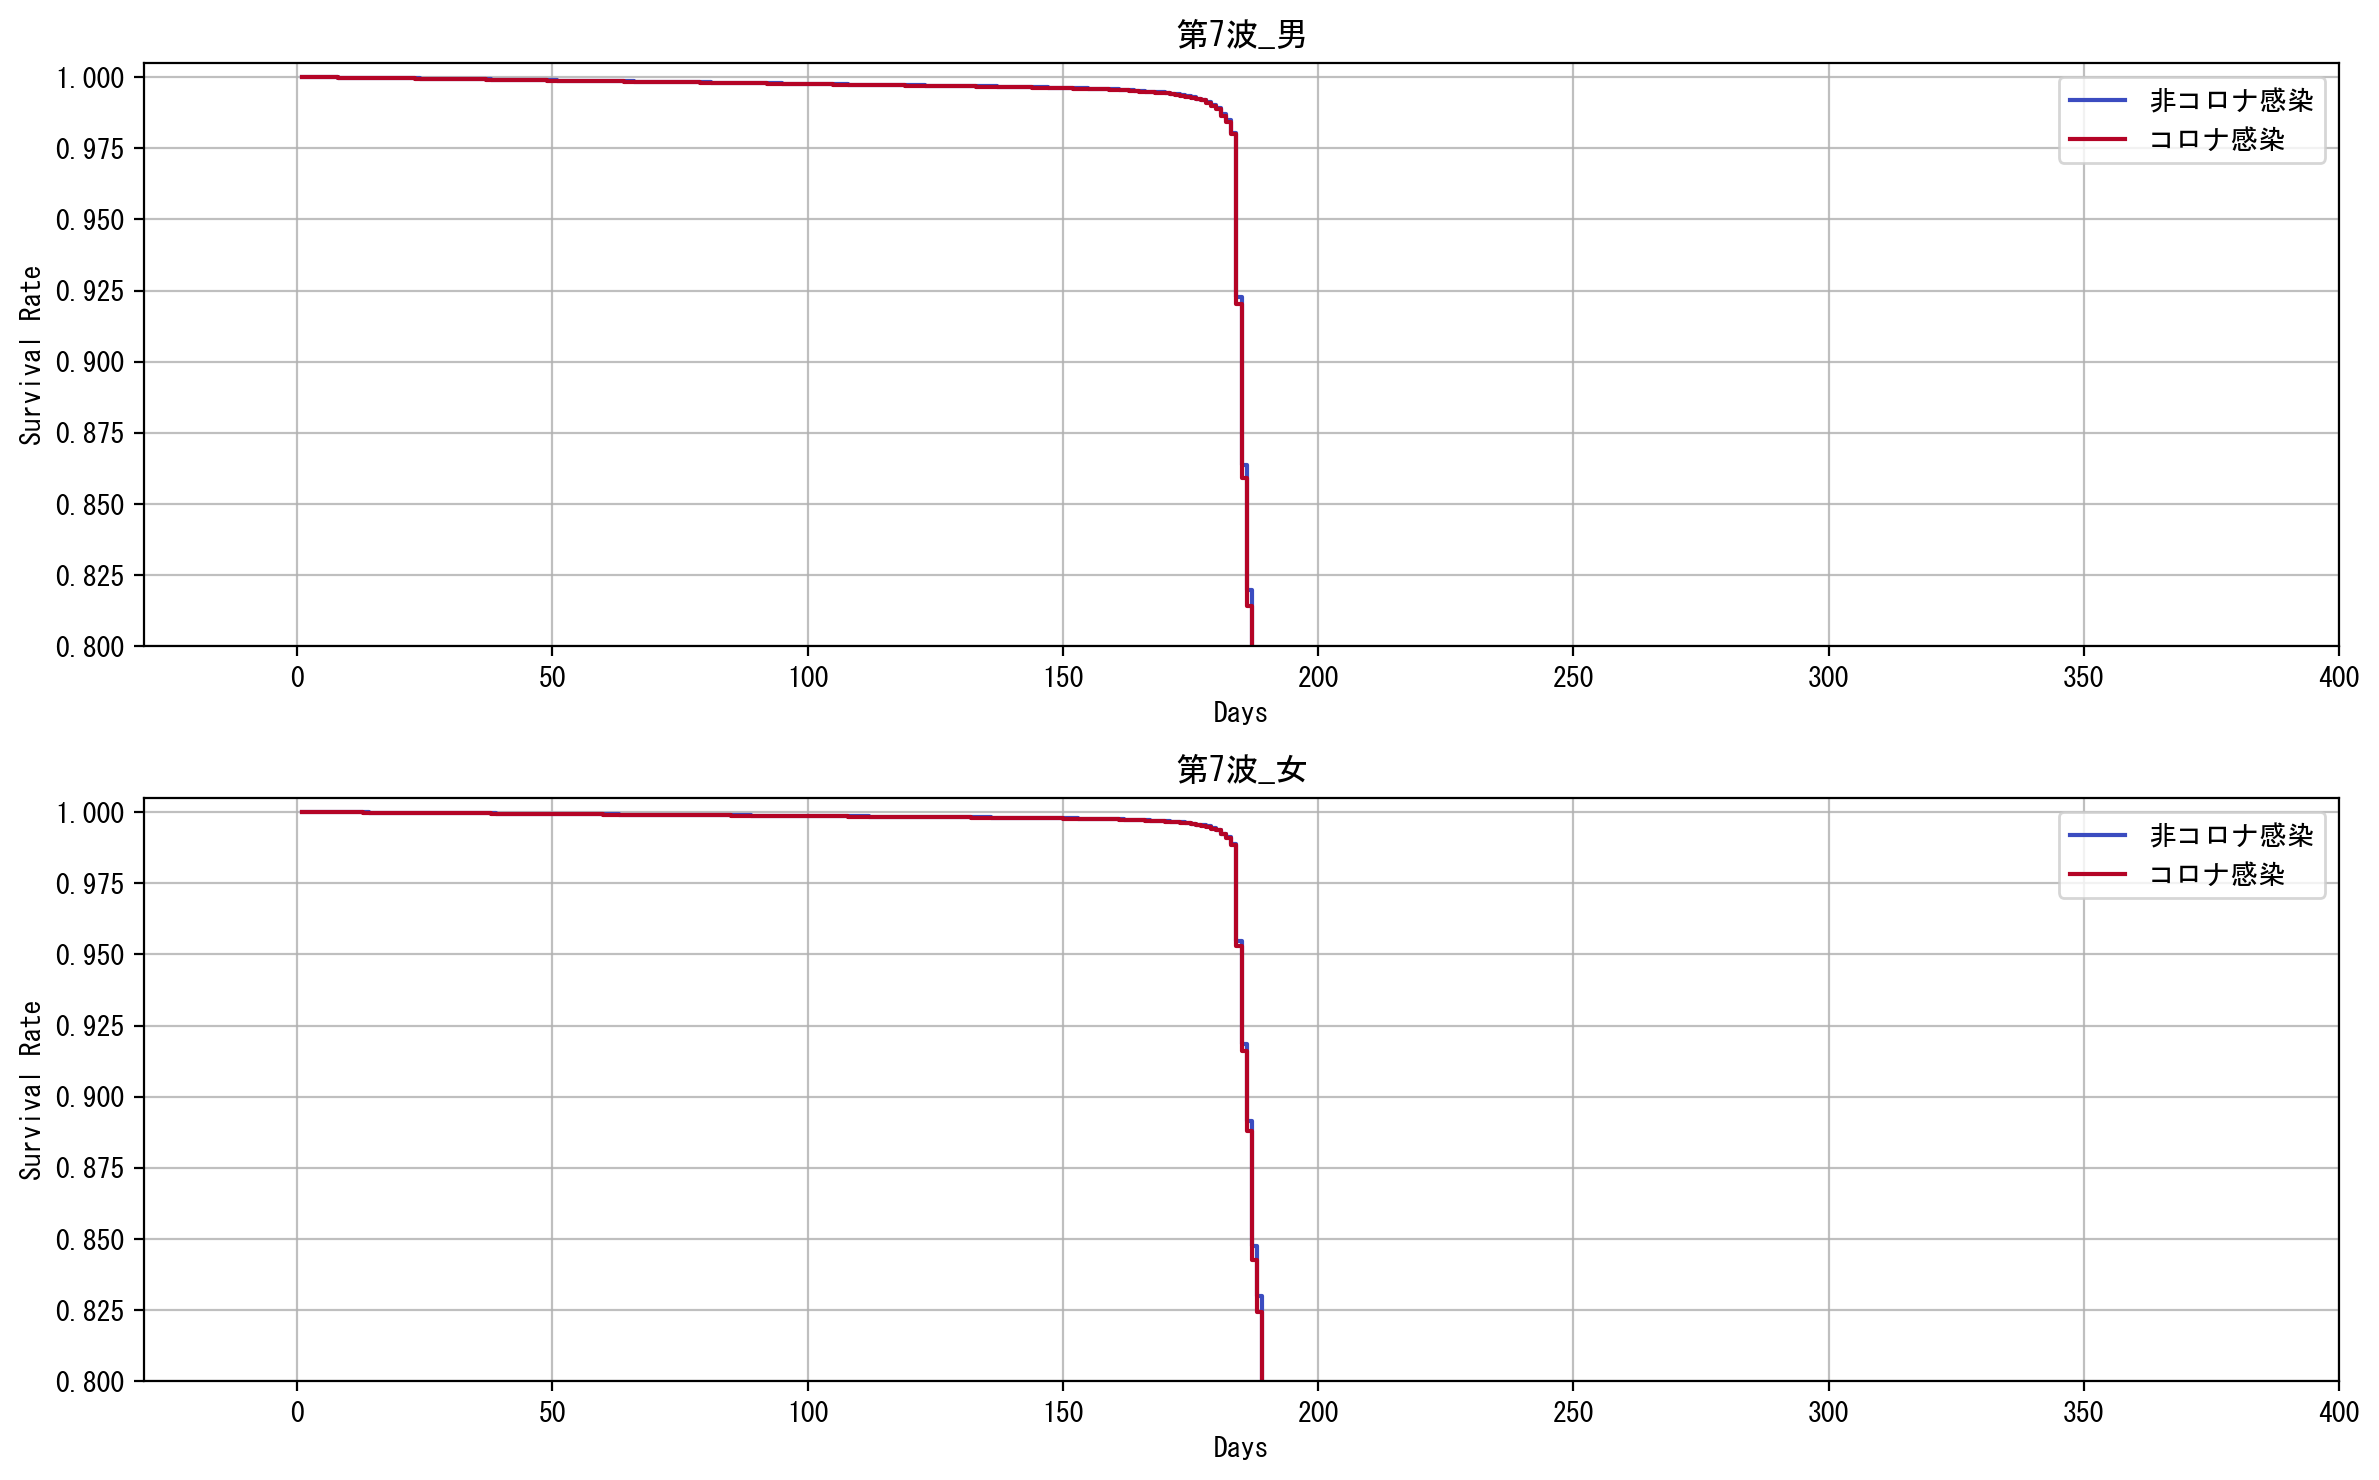

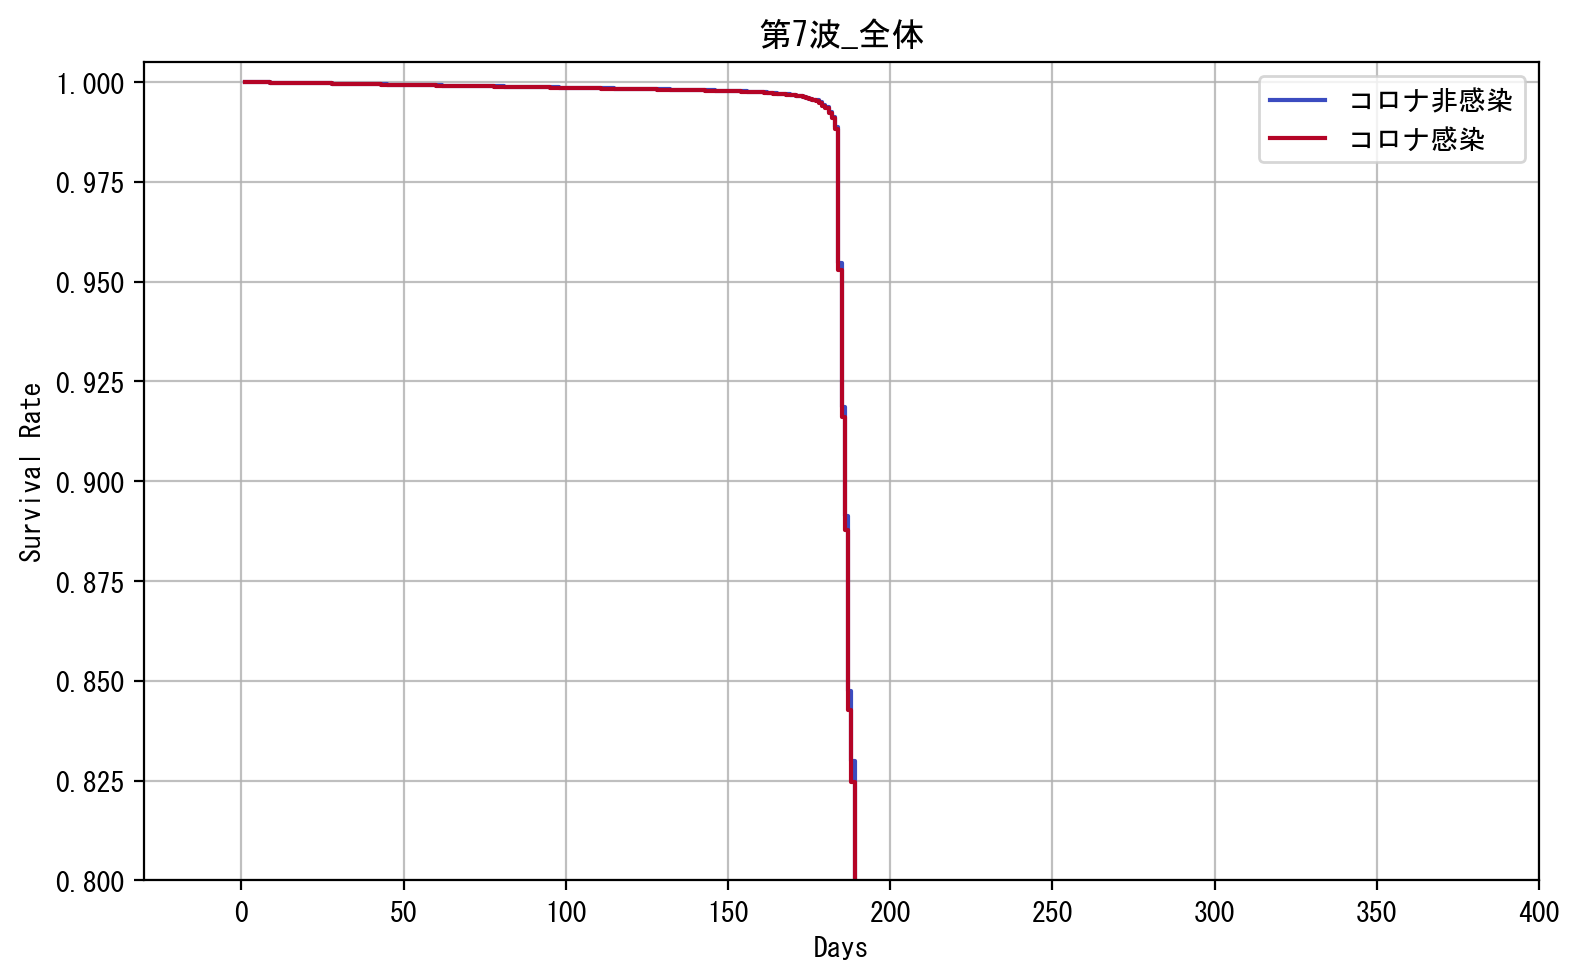

100%|██████████| 5/5 [00:35<00:00,  7.01s/it]


In [23]:
version = '前処理あり_v2' # '前処理あり' or '前処理なし'
target_duration = '1y' # 1y or 2m 

if target_duration == '2m':
    xlim = (-10, 70)
elif target_duration == '1y':
    xlim = (-30, 400)

# 空の辞書を作成
cox_dict = {}

# 分析対象のデータのラベルのリスト
data_list = ['2020年度', '第4波', '第5波', '第6波', '第7波']

# 各データ波の期間を示す辞書
duration_dict = {
    '2020年度': [20200401, 20210331],
    '第4波': [20210401, 20210531],
    '第5波': [20210701, 20210930],
    '第6波': [20220101, 20220331],
    '第7波': [20220701, 20220930]
}

# フォントの設定
plt.rcParams["font.family"] = 'MS Gothic'

with pd.ExcelWriter(f'./output/cox分析_{version}_{target_duration}.xlsx') as writer:
    for wave in tqdm(data_list):
        data_with_dummies = pd.read_csv(f'cox分析用データ_{wave}_{version}_{target_duration}.csv', encoding='cp932')
        #基準となる変数の削除
        data_with_dummies.drop(columns=['age_kbn_4_40代', 'pref_nm_13_東京', 'sex_type_nm_女'], inplace=True)


        cph = CoxPHFitter()
        cph.fit(data_with_dummies, duration_col='diabetes_days', event_col=f'Diabetes_flag_{target_duration}')

        #ハザード比の出力
        #基準となる'age_kbn_4_40代', 'pref_nm_13_東京', 'sex_type_nm_女'は表に含まれていないため、出力後のファイルに追加してください。
        #それらは基準であるため、ハザード比も1だとかんがえられます。
        summary_df = cph.summary
        summary_df = summary_df[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]
        summary_df.to_excel(writer, sheet_name=wave, encoding='cp932')

        cox_dict[wave] = cph

        ### age ####
        targets = ['0_10歳未満', '1_10代', '2_20代', '3_30代', '4_40代', '5_50代', '6_60代以上']
        fig = plt.figure(figsize=(16,10),dpi=200)
        for i, t in enumerate(targets):
            if t == '4_40代':
                values = [[0,0], [0,1]]
                cov = 'age_kbn_0_10歳未満'
            else:
                values = [[1,0], [1,1]]
                cov = 'age_kbn_'+t
            # グラフの設定
            ax=fig.add_subplot(3, 3, i+1)

            # グラフの描画
            cph.plot_partial_effects_on_outcome(covariates=[cov, 'covid_flag'], 
                                                values=values, cmap='coolwarm', plot_baseline=False, ax=ax)

            # グラフにタイトルを追加
            ax.set_title(f"{wave}_{t}")

            # x 軸ラベルの設定
            ax.set_xlabel("Days")

            # y 軸ラベルの設定
            ax.set_ylabel("Survival Rate")

            ax.set_ylim(0.80, 1.005)
            ax.set_xlim(xlim)
            ax.grid(alpha=0.8)
            # legend
            ax.legend(['非コロナ感染', 'コロナ感染'])
        plt.tight_layout()
        plt.savefig(f"./output/{wave}_age_{version}_{target_duration}.png")
        plt.show()

        ### sex ####
        targets = ['男', '女']
        fig = plt.figure(figsize=(12,7.5),dpi=200)
        for i, t in enumerate(targets):
            if t == '女':
                values = [[0,0], [0,1]]
                cov = 'sex_type_nm_男'
            else:
                values = [[1,0], [1,1]]
                cov = 'sex_type_nm_'+t
            # グラフの設定
            ax=fig.add_subplot(2, 1, i+1)

            # グラフの描画
            cph.plot_partial_effects_on_outcome(covariates=[cov, 'covid_flag'], 
                                                values=values, cmap='coolwarm', plot_baseline=False, ax=ax)

            # グラフにタイトルを追加
            ax.set_title(f"{wave}_{t}")

            # x 軸ラベルの設定
            ax.set_xlabel("Days")

            # y 軸ラベルの設定
            ax.set_ylabel("Survival Rate")

            ax.set_ylim(0.80, 1.005)
            ax.set_xlim(xlim)
            ax.grid(alpha=0.8)
            # legend
            ax.legend(['非コロナ感染', 'コロナ感染'])
        plt.tight_layout()
        plt.savefig(f"./output/{wave}_sex_{version}_{target_duration}.png")
        plt.show()
        
        ### 全体 ####
        covariates = ['covid_flag']
        # グラフの設定
        fig = plt.figure(figsize=(8,5),dpi=200)
        ax=fig.add_subplot()
#         plt.rcParams["font.family"] = 'MS Gothic'

        # グラフの描画
        cph.plot_partial_effects_on_outcome(covariates=covariates, 
                                            values=[0,1], cmap='coolwarm', plot_baseline=False, ax=ax)

        # グラフにタイトルを追加
        ax.set_title(f"{wave}_全体")

        # x 軸ラベルの設定
        ax.set_xlabel("Days")

        # y 軸ラベルの設定
        ax.set_ylabel("Survival Rate")

        # legend
        ax.legend(['コロナ非感染','コロナ感染'])
        ax.set_ylim(0.80, 1.005)
        ax.set_xlim(xlim)
        ax.grid(alpha=0.8)
        plt.tight_layout()
        plt.savefig(f"./output/{wave}_全体_{version}_{target_duration}.png")
        plt.show()